# Empirical evaluation of the impact of labels and templates on pull request quality

In [ ]:
%matplotlib inline

import sys
print(f'Python {sys.version}')

import IPython
print(f'IPython {IPython.__version__}')

print('\nLibraries:\n')

import matplotlib
import matplotlib.pyplot as plt
print(f'matplotlib {matplotlib.__version__}')

import numpy as np
print(f'numpy {np.__version__}')

import pandas as pd
from pandas.plotting import register_matplotlib_converters
print(f'pandas {pd.__version__}')

import requests
print(f'requests {requests.__version__}')

import scipy
from scipy.optimize import curve_fit
print(f'scipy {scipy.__version__}')

import statsmodels
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import summary_table
print(f'statsmodels {statsmodels.__version__}')

Python 3.7.4 (default, Jul  8 2019, 18:31:06) 
[GCC 7.4.0]
IPython 7.6.1

Libraries:

matplotlib 3.1.1
numpy 1.17.0
pandas 0.25.0
requests 2.22.0
scipy 1.3.0
statsmodels 0.10.1


In [ ]:
plt.rcParams.update({
    'figure.figsize': [6, 6],
    'xtick.labelsize': 7,
    'ytick.labelsize': 7,
    'legend.fontsize': 7,
    'axes.titlesize': 8,
    'legend.frameon': True,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.05,
    'lines.linewidth': 1,
    'figure.dpi': 300.0
})

register_matplotlib_converters()

## Definitions

### Labels `needs:`

In [ ]:
date_intro_needs_doc = pd.to_datetime('2017-08-09T09:53:13Z')
date_intro_needs_CHANGES = pd.to_datetime('2018-03-22T10:41:32Z')
date_intro_needs_tests = pd.to_datetime('2018-05-28T16:08:35Z')

### Introduction of checkboxes in PR template

The PR template is introduced at the end of December with a checkbox for the documentation and one for the `CHANGES` file.
Then it receives the addition of a checkbox for tests in June.

In [ ]:
date_intro_template = pd.to_datetime('2017-12-29T14:04:09Z')
date_tests_template = pd.to_datetime('2018-06-04T08:30:12Z')

The `needs: documentation` label has been introduced 142 days before the PR template with the documentation checkbox.

In [ ]:
date_intro_template - date_intro_needs_doc

Timedelta('142 days 04:10:56')

The `needs: CHANGES` label has been introduced 82 days after the PR tempalte with the `CHANGES` checkbox.

In [ ]:
date_intro_needs_CHANGES - date_intro_template

Timedelta('82 days 20:37:23')

The `needs: test-suite update` and the tests checkbox in the PR template were introduced within one week of each other, which makes it impossible to differentiate the effect of the two.

In [ ]:
date_tests_template - date_intro_needs_tests

Timedelta('6 days 16:21:37')

The test checkbox is the PR template was introduced 156 days after the initial version of the PR template.

In [ ]:
date_tests_template - date_intro_template

Timedelta('156 days 18:26:03')

It was also introduced more than 450 days ago, which gives sufficient room for testing large bandwidths as robustness checks.

In [ ]:
date_tests_template + pd.Timedelta(450,'D')

Timestamp('2019-08-28 08:30:12+0000', tz='UTC')

### End of the `CHANGES` file

From this date, the changelog has been moved to the doc, so we stop measuring how many PRs change the doc or the changelog.

In [ ]:
date_end_of_CHANGES = pd.to_datetime('2019-05-06T13:08:52Z')

This occurred 492 days after the template was initially introduced, which gives sufficient room for testing large bandwidths as robustness checks.

In [ ]:
date_end_of_CHANGES - date_intro_template

Timedelta('492 days 23:04:43')

## Data collection

This part can be skipped by reusing the provided CSV file.

In [ ]:
api_token = ''

def send_graphql_request(query, variables):
    headers = {'Authorization': f'token {api_token}'}
    url = 'https://api.github.com/graphql'
    json = {'query':query, 'variables':variables}
    r = requests.post(url=url, json=json, headers=headers)
    r.raise_for_status() # Abort if unsuccessful request
    return r.json()

In [ ]:
query = '''
query pullRequestFiles($owner: String!, $repo: String!, $cursor: String) {
  repository(owner: $owner, name: $repo) {
    pullRequests(first: 30, after: $cursor) {
      nodes {
        number
        createdAt
        merged
        author { login }
        labels(first: 100) {
          nodes {
            name
          }
        }
        changedFiles
        files(first: 100) {
          nodes {
            path
          }
        }
      }
      pageInfo {
        hasNextPage
        endCursor
      }
    }
  }
}
'''

Signficant dates:

In [ ]:
columns = [
    'number',
    'merged',
    'author',
    'feature', 'enhancement', 'fix',
    'changedFiles',
    'changeDoc', 'onlyDoc',
    'changeCHANGES', 'onlyCHANGES',
    'changeTests', 'onlyTests'
]
values = pd.DataFrame(columns=columns)
next_page = True
cursor = None
while next_page:
    json = send_graphql_request(query,{'owner': 'coq', 'repo': 'coq', 'cursor': cursor})
    pr_json = json['data']['repository']['pullRequests']
    page_info = pr_json['pageInfo']
    next_page = page_info['hasNextPage']
    cursor = page_info['endCursor']
    for node in pr_json['nodes']:
        # Index
        date = pd.to_datetime(node['createdAt'])
        # Number, merged status, and author
        values.loc[date, 'merged'] = node['merged']
        values.loc[date, 'number'] = node['number']
        values.loc[date, 'author'] = node['author']['login']
        # Labels
        labels = list(map(lambda label: label['name'], node['labels']['nodes']))
        values.loc[date, 'feature'] = any(label == 'kind: feature' for label in labels)
        values.loc[date, 'enhancement'] = any(label == 'kind: enhancement' for label in labels)
        values.loc[date, 'fix'] = any(label == 'kind: fix' for label in labels)
        # Changed files
        changedFiles = node['changedFiles']
        values.loc[date, 'changedFiles'] = changedFiles
        if changedFiles > 0 and changedFiles <= 100:
            # We do nothing if there are more than 100 changed files
            # Otherwise we would not have the complete list
            files = list(map(lambda file: file['path'], node['files']['nodes']))
            if date < date_end_of_CHANGES:
                # After this date, CHANGES has been moved to doc/changelog
                values.loc[date, 'changeDoc'] = any(file.startswith('doc/') for file in files)
                values.loc[date, 'onlyDoc'] = all(file.startswith('doc/') for file in files)
                values.loc[date, 'changeCHANGES'] = any(file.startswith('CHANGES') for file in files)
                values.loc[date, 'onlyCHANGES'] = all(file.startswith('CHANGES') for file in files)
            values.loc[date, 'changeTests'] = any(file.startswith('test-suite/') for file in files)
            values.loc[date, 'onlyTests'] = all(file.startswith('test-suite/') for file in files)
    sys.stdout.write(f'Current date: {date}\r')
    sys.stdout.flush()

In [ ]:
values.to_csv('templates.csv')

## Data analysis

It is possible to jump over the previous part of the CSV file is available.

In [ ]:
values = pd.read_csv('templates.csv', index_col=0, parse_dates=True)
len(values)

3858

### Preprocessing

Remove pull requests which are pure doc, pure CHANGES, or pure tests, because we are interested specifically in the impact on the other kind of pull requests.

In [ ]:
len(values[values['onlyDoc'] == True]) / len(values)

0.05754276827371695

In [ ]:
len(values[values['onlyCHANGES'] == True]) / len(values)

0.005702436495593572

In [ ]:
len(values[values['onlyTests'] == True]) / len(values)

0.02592016588906169

In [ ]:
len(values[pd.isnull(values['onlyTests'])]) / len(values)

0.01658890616899948

In [ ]:
values = values[values['onlyDoc'] != True]
values = values[values['onlyCHANGES'] != True]
values = values[values['onlyTests'] != True]
len(values)

3514

### Regression discontinuity design

In the following RDDs, we display the table with estimated coefficients and p-values, then we show a graph, with the estimated results, and the actual measures averaged over periods of one week.

In [ ]:
# The cutoff is the date of the treatment
# The bandwidth is the number of days to select before and after the treatment
# The variable is the one on which we want to measure an effect: any of 'Doc', 'CHANGES', or 'Tests'
def rdd(cutoff, bandwidth, variable, values=values, plot_windows=7, degree=1):
    start = cutoff - pd.Timedelta(days=bandwidth)
    end = cutoff + pd.Timedelta(days=bandwidth)
    rdd_data = values[(values.index >= start) & (values.index <= end)].copy()[[f'change{variable}']]
    rdd_data = rdd_data.dropna()
    rdd_data['afterEvent'] = rdd_data.index > cutoff
    rdd_data['reldate'] = (rdd_data.index - cutoff).days
    obs_before_cutoff = rdd_data[~rdd_data['afterEvent']]
    obs_after_cutoff = rdd_data[rdd_data['afterEvent']]
    rdd_data = rdd_data.astype(float)
    formula = f'change{variable} ~ afterEvent'
    if degree >= 1:
        formula += ' + reldate + afterEvent * reldate'
    if degree >= 2:
        formula += ' + reldate_square + afterEvent * reldate_square'
    results = smf.ols(
        formula = formula,
        data=rdd_data.assign(reldate_square=rdd_data['reldate']*rdd_data['reldate'])
    ).fit(cov_type='HC1')
    print(results.summary2(float_format='%.3g'))
    #print(results.pvalues)
    
    plt.plot(obs_before_cutoff['reldate'], results.predict()[:len(obs_before_cutoff)], color='black')
    plt.plot(obs_after_cutoff['reldate'], results.predict()[len(obs_before_cutoff):], color='black')
    
    _, data, _ = summary_table(results, alpha=0.05)
    # Get the confidence intervals of the model
    low_CI, upper_CI = data[:,4:6].T

    # Shade the confidence interval
    plt.fill_between(obs_before_cutoff['reldate'],low_CI[:len(obs_before_cutoff)],upper_CI[:len(obs_before_cutoff)],color='black',alpha=0.2)
    plt.fill_between(obs_after_cutoff['reldate'],low_CI[len(obs_before_cutoff):],upper_CI[len(obs_before_cutoff):],color='black',alpha=0.2)
    
    plot_data = rdd_data.assign(long_period = rdd_data['reldate'] // plot_windows).groupby('long_period').agg({
        'reldate': lambda x: (np.min(x) + np.max(x)) / 2,
        f'change{variable}': 'mean'
    })
    plt.plot(plot_data['reldate'], plot_data[f'change{variable}'], '.')
    
    plt.ylim(bottom=-0.01)
    plt.show()

#### Effect of `needs:` labels

In both cases (`needs: documentation` and `needs: CHANGES`) there is no measurable effect. This is reasonable as the use of this label is mostly to help reviewers but if they thought about the missing documentation or update to `CHANGES` there were likely able to ensure through other ways that this would be added.

##### Effect of `needs: documentation` label on presence of documentation in pull requests

We take the maximum possible bandwidth that does not also include the introduction of the PR template. The RDD does not show any significant effect of the introduction of this label. Furthermore, the estimated coefficient is even negative.

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.001   
Dependent Variable: changeDoc        AIC:                58.8062 
Date:               2019-09-13 11:58 BIC:                77.8709 
No. Observations:   868              Log-Likelihood:     -25.403 
Df Model:           3                F-statistic:        1.050   
Df Residuals:       864              Prob (F-statistic): 0.369   
R-squared:          0.004            Scale:              0.062367
-----------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
-----------------------------------------------------------------
Intercept           0.1136   0.0297  3.8291 0.0001  0.0555 0.1718
afterEvent         -0.0611   0.0395 -1.5477 0.1217 -0.1385 0.0163
reldate             0.0005   0.0003  1.6405 0.1009 -0.0001 0.0012
afterEvent:reldate -0.0005   0.0004 -1.0280 0.3040 -0.0013 0.0004
---------------------------

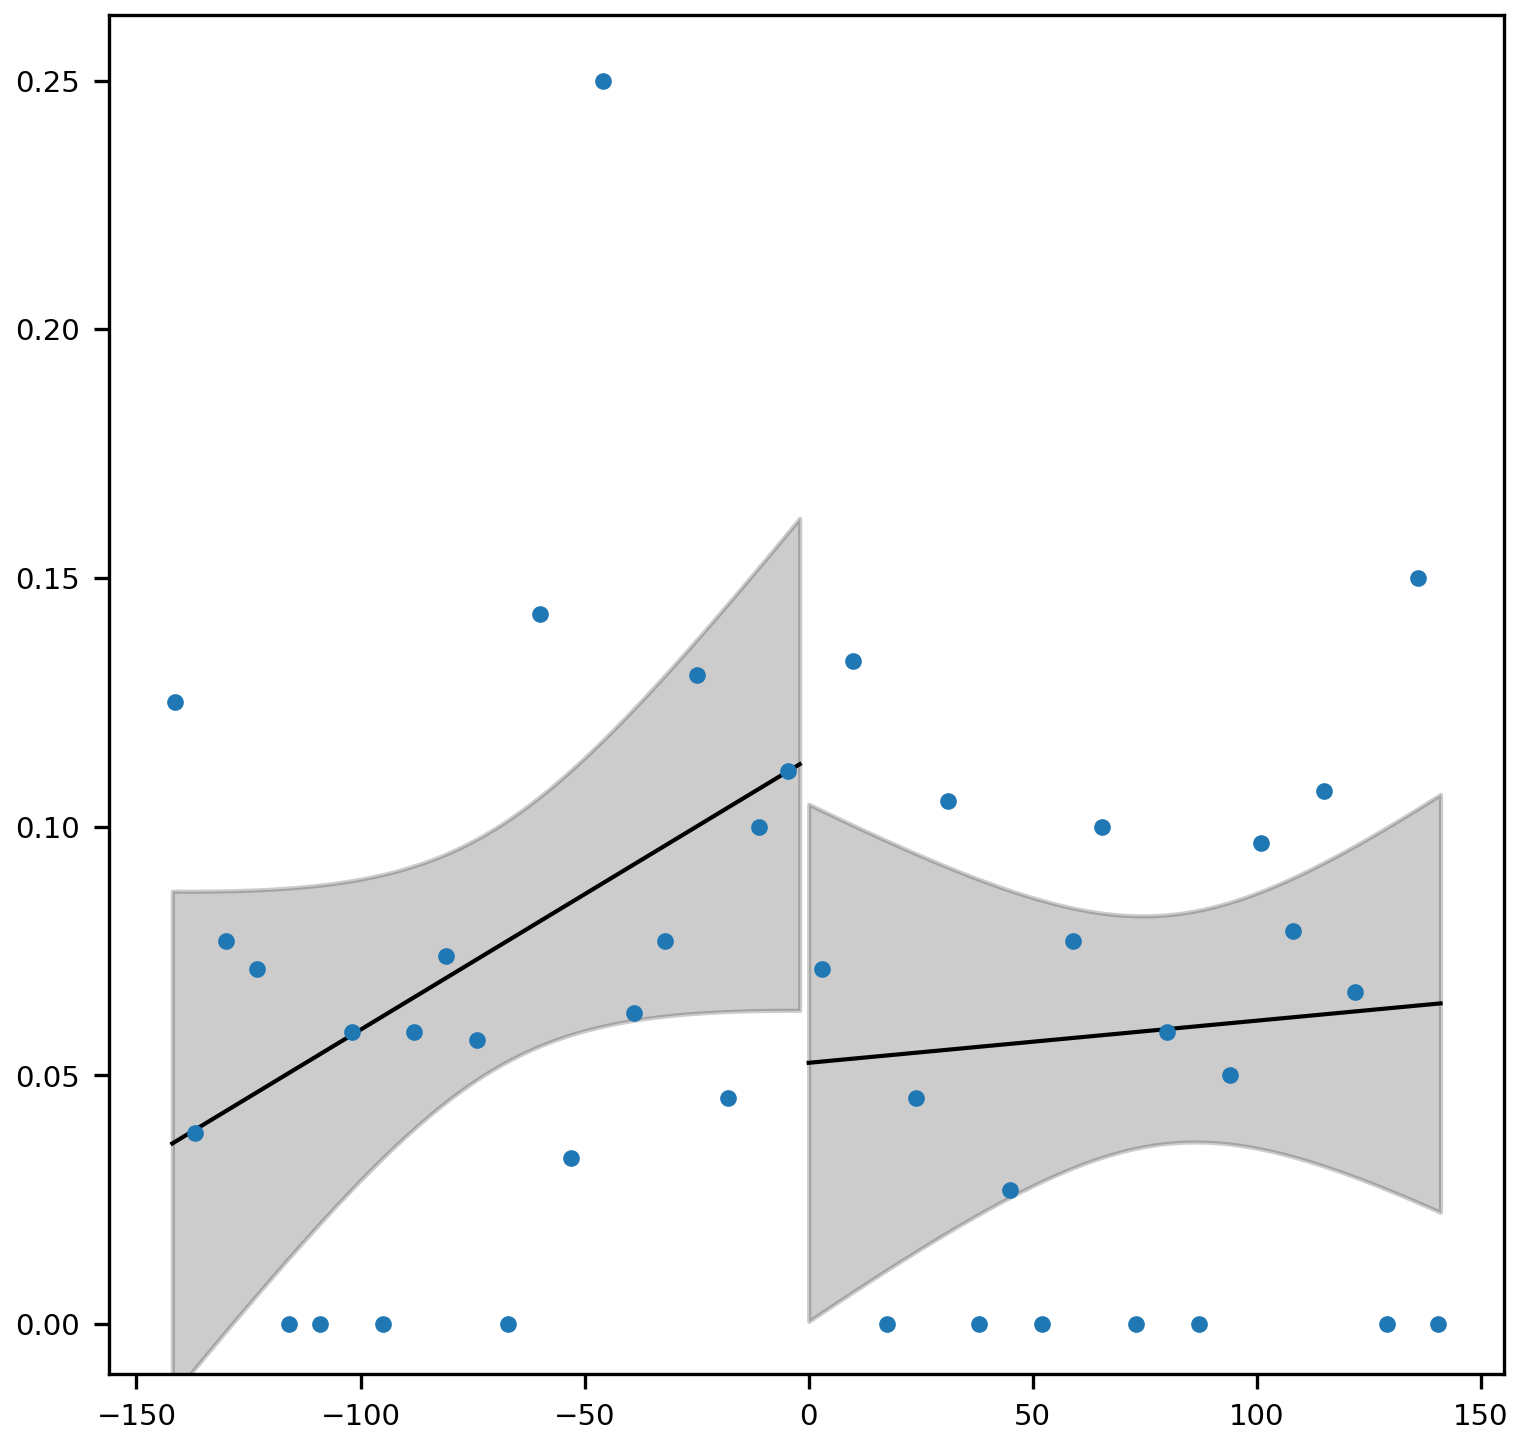

In [ ]:
results = rdd(date_intro_needs_doc, 142, 'Doc', values)

##### Effect of `needs: CHANGES` label on the modification of the `CHANGES` file

We take the maximum possible bandwidth that does not also include the introduction of the PR template. The RDD does not show any significant effect of the introduction of this label. Furthermore, the estimated coefficient is even negative.

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.003   
Dependent Variable: changeCHANGES    AIC:                297.4420
Date:               2019-09-13 12:02 BIC:                315.1285
No. Observations:   615              Log-Likelihood:     -144.72 
Df Model:           3                F-statistic:        1.468   
Df Residuals:       611              Prob (F-statistic): 0.222   
R-squared:          0.008            Scale:              0.094353
-----------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
-----------------------------------------------------------------
Intercept           0.1048   0.0350  2.9925 0.0028  0.0362 0.1735
afterEvent         -0.0168   0.0456 -0.3685 0.7125 -0.1062 0.0726
reldate            -0.0009   0.0009 -0.9379 0.3483 -0.0027 0.0010
afterEvent:reldate  0.0008   0.0011  0.6918 0.4891 -0.0014 0.0030
---------------------------

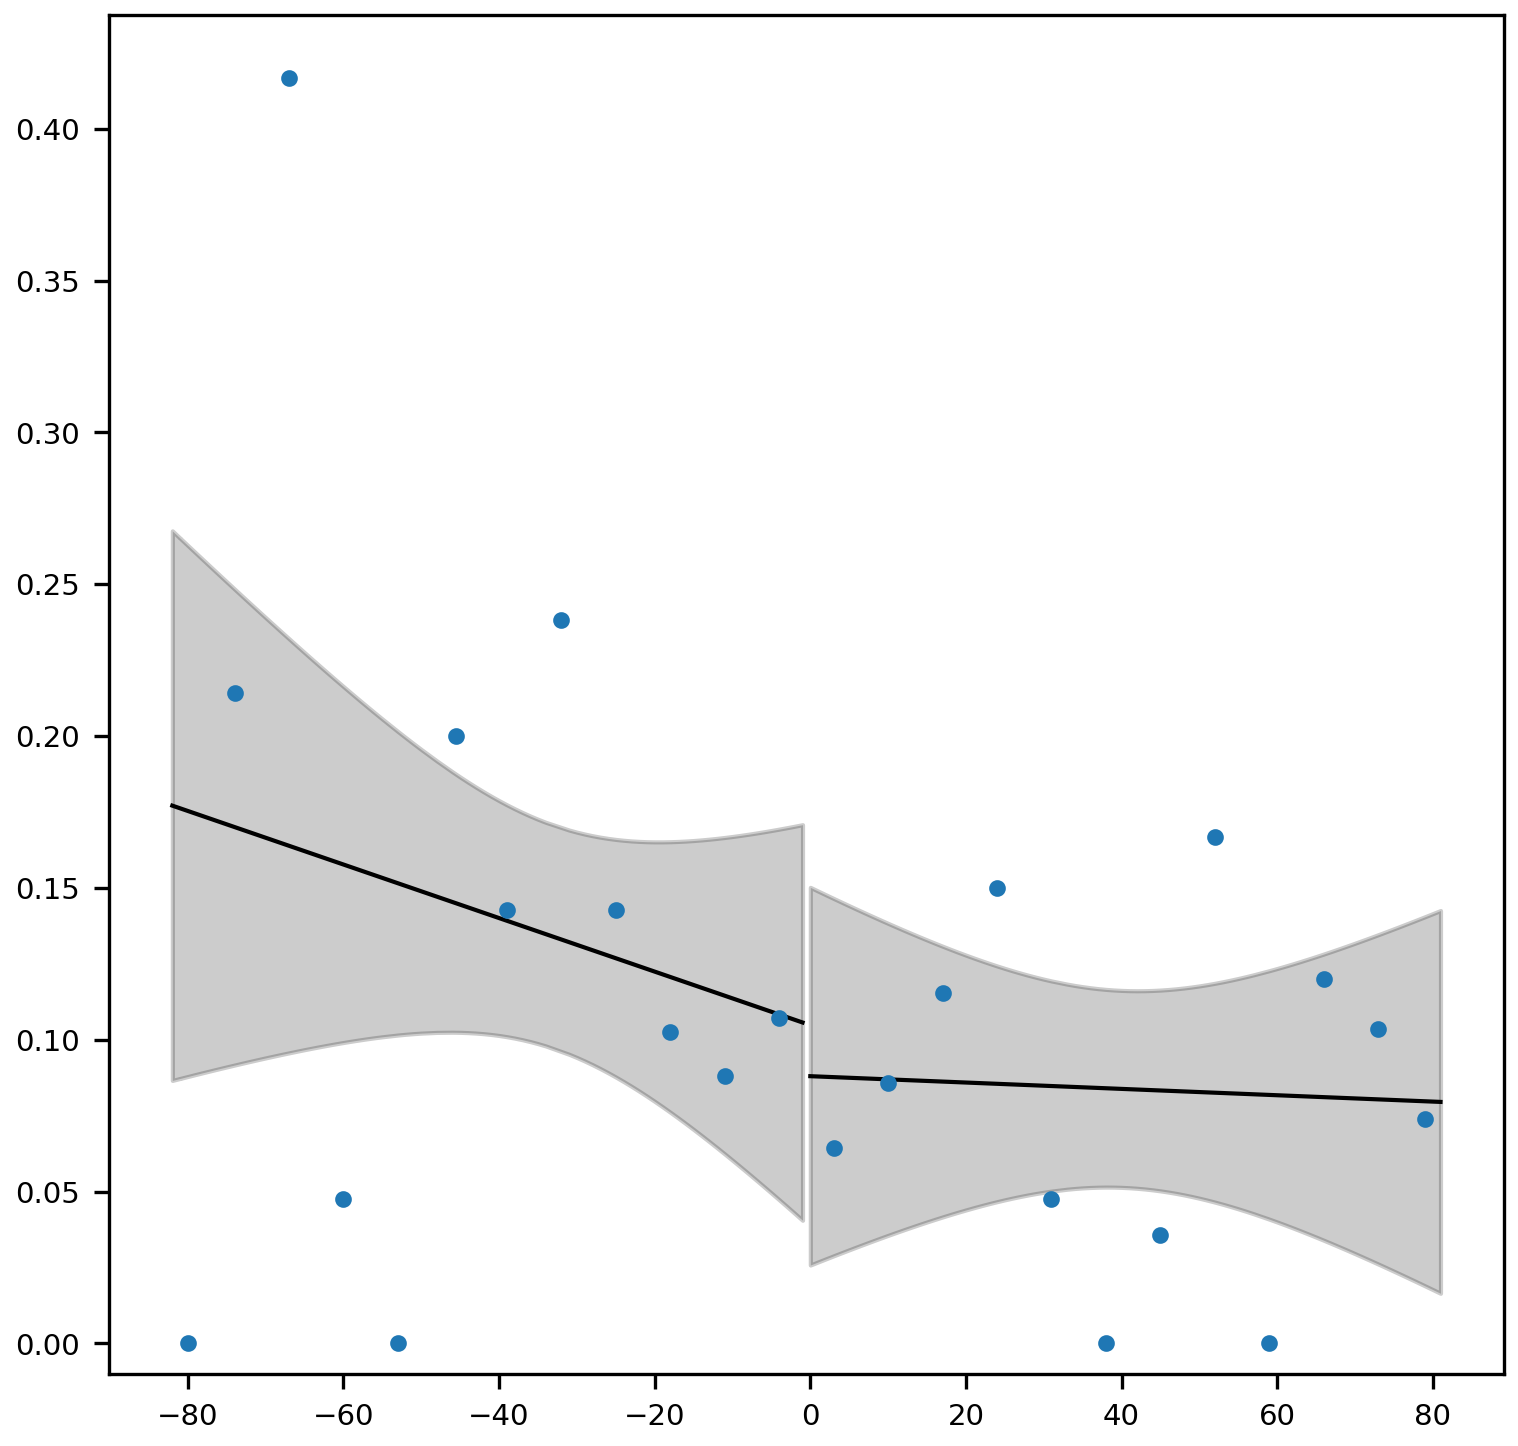

In [ ]:
rdd(date_intro_needs_CHANGES, 82, 'CHANGES', values)

#### Effect of the introduction of the pull request template

Given that we have found no significant effect and even a negative estimated coefficient in the previous regressions, it is safe to include larger bandwidth for measuring the effect of the introduction of the pull request template. We observe strong significant effects of this template, on both updates to the documentation and to the `CHANGES` file. This is likely because the presence of the template has reminded both the contributor and the reviewer that these updates were needed.

##### Effect on presence of documentation in pull requests

The introduction of the template increased the number of pull requests with documentation by 140%, from about 6% to about 15%.

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.016   
Dependent Variable: changeDoc        AIC:                466.8127
Date:               2019-09-13 12:04 BIC:                486.4795
No. Observations:   1009             Log-Likelihood:     -229.41 
Df Model:           3                F-statistic:        6.717   
Df Residuals:       1005             Prob (F-statistic): 0.000173
R-squared:          0.019            Scale:              0.092626
-----------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
-----------------------------------------------------------------
Intercept           0.0625   0.0217  2.8749 0.0040  0.0199 0.1051
afterEvent          0.0950   0.0378  2.5138 0.0119  0.0209 0.1691
reldate             0.0000   0.0003  0.1301 0.8965 -0.0005 0.0006
afterEvent:reldate -0.0002   0.0004 -0.4806 0.6308 -0.0011 0.0006
---------------------------

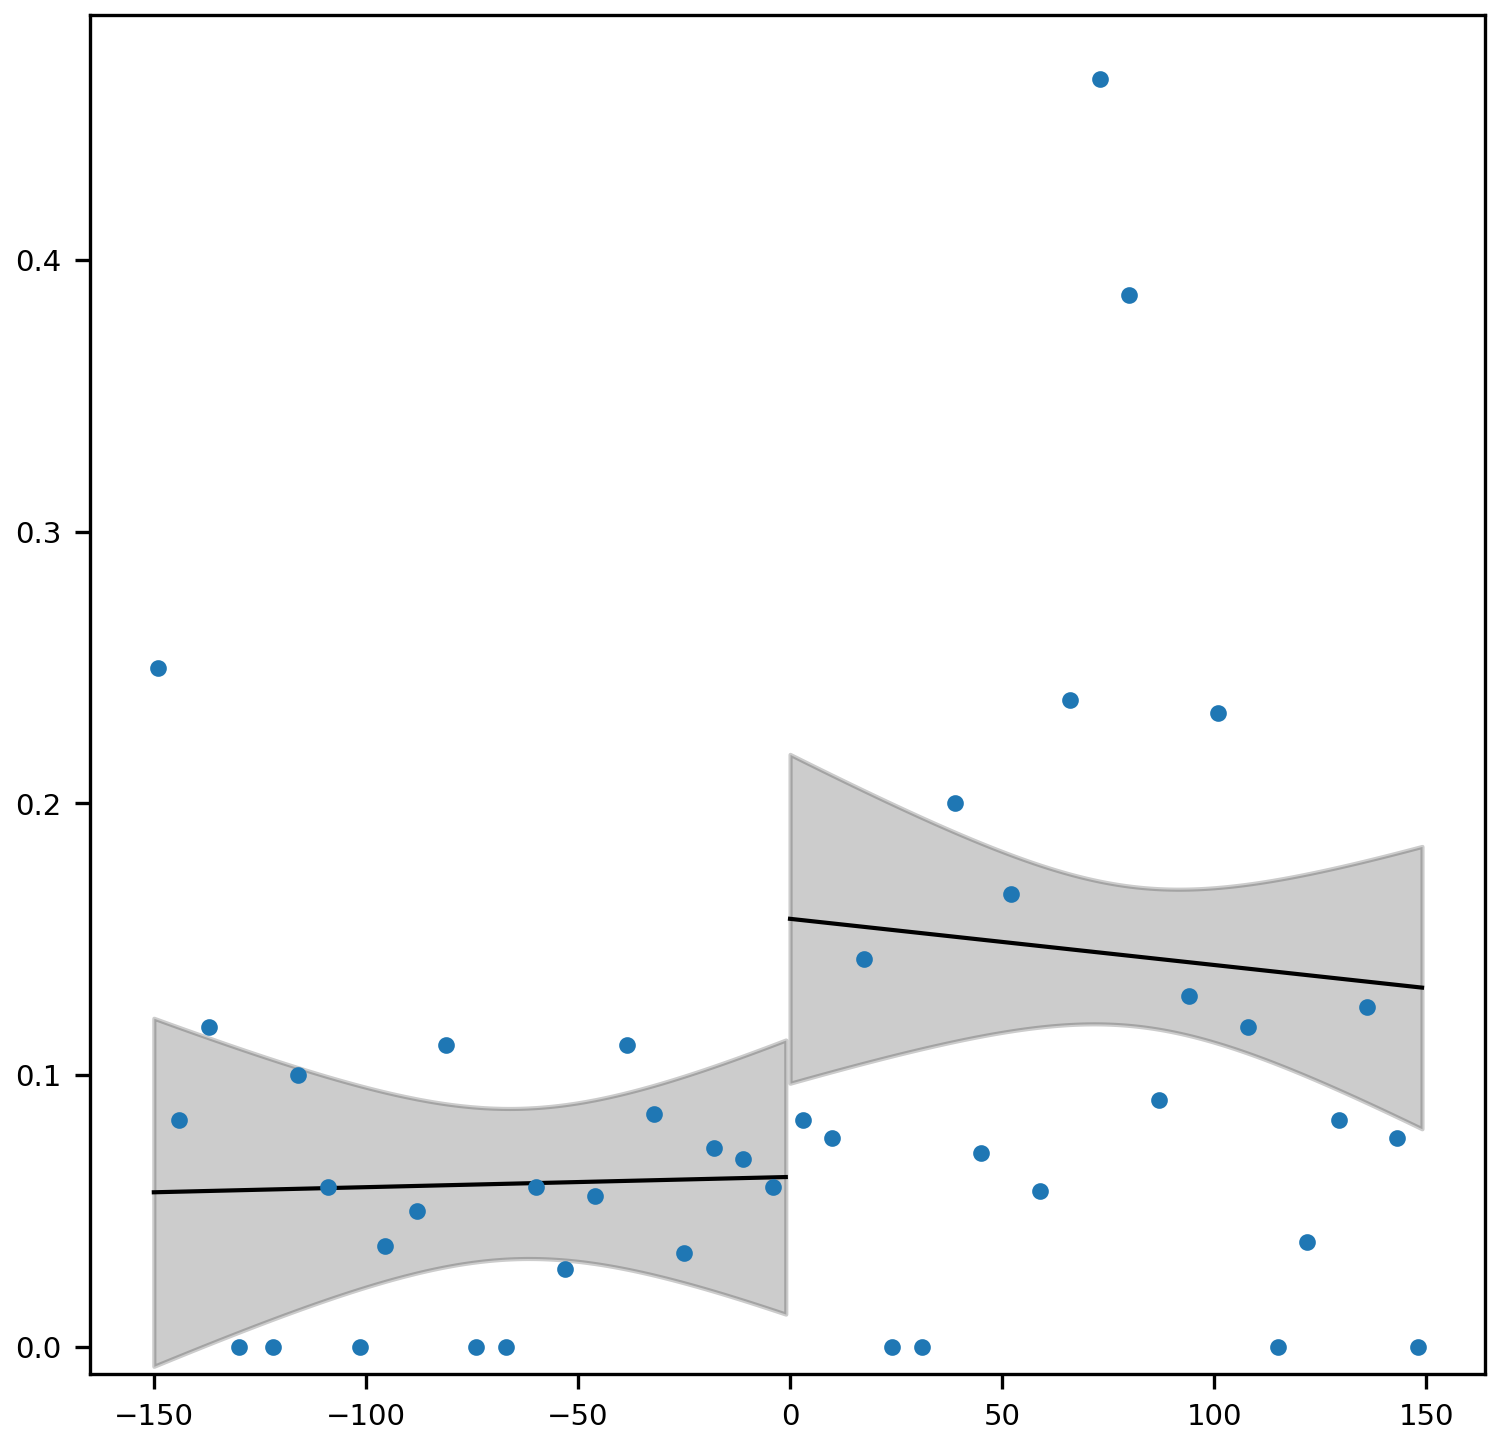

In [ ]:
rdd(date_intro_template, 150, 'Doc')

##### Effect on the modification of the `CHANGES` file

The introduction of the template strongly increased the number of pull requests that updated the `CHANGES` file, whereas it was close to zero before.

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.015   
Dependent Variable: changeCHANGES    AIC:                223.9703
Date:               2019-09-13 12:07 BIC:                243.6372
No. Observations:   1009             Log-Likelihood:     -107.99 
Df Model:           3                F-statistic:        5.049   
Df Residuals:       1005             Prob (F-statistic): 0.00178 
R-squared:          0.018            Scale:              0.072813
-----------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
-----------------------------------------------------------------
Intercept           0.0362   0.0213  1.6941 0.0902 -0.0057 0.0780
afterEvent          0.1329   0.0403  3.2929 0.0010  0.0538 0.2119
reldate            -0.0002   0.0003 -0.6585 0.5102 -0.0008 0.0004
afterEvent:reldate -0.0006   0.0005 -1.1806 0.2378 -0.0015 0.0004
---------------------------

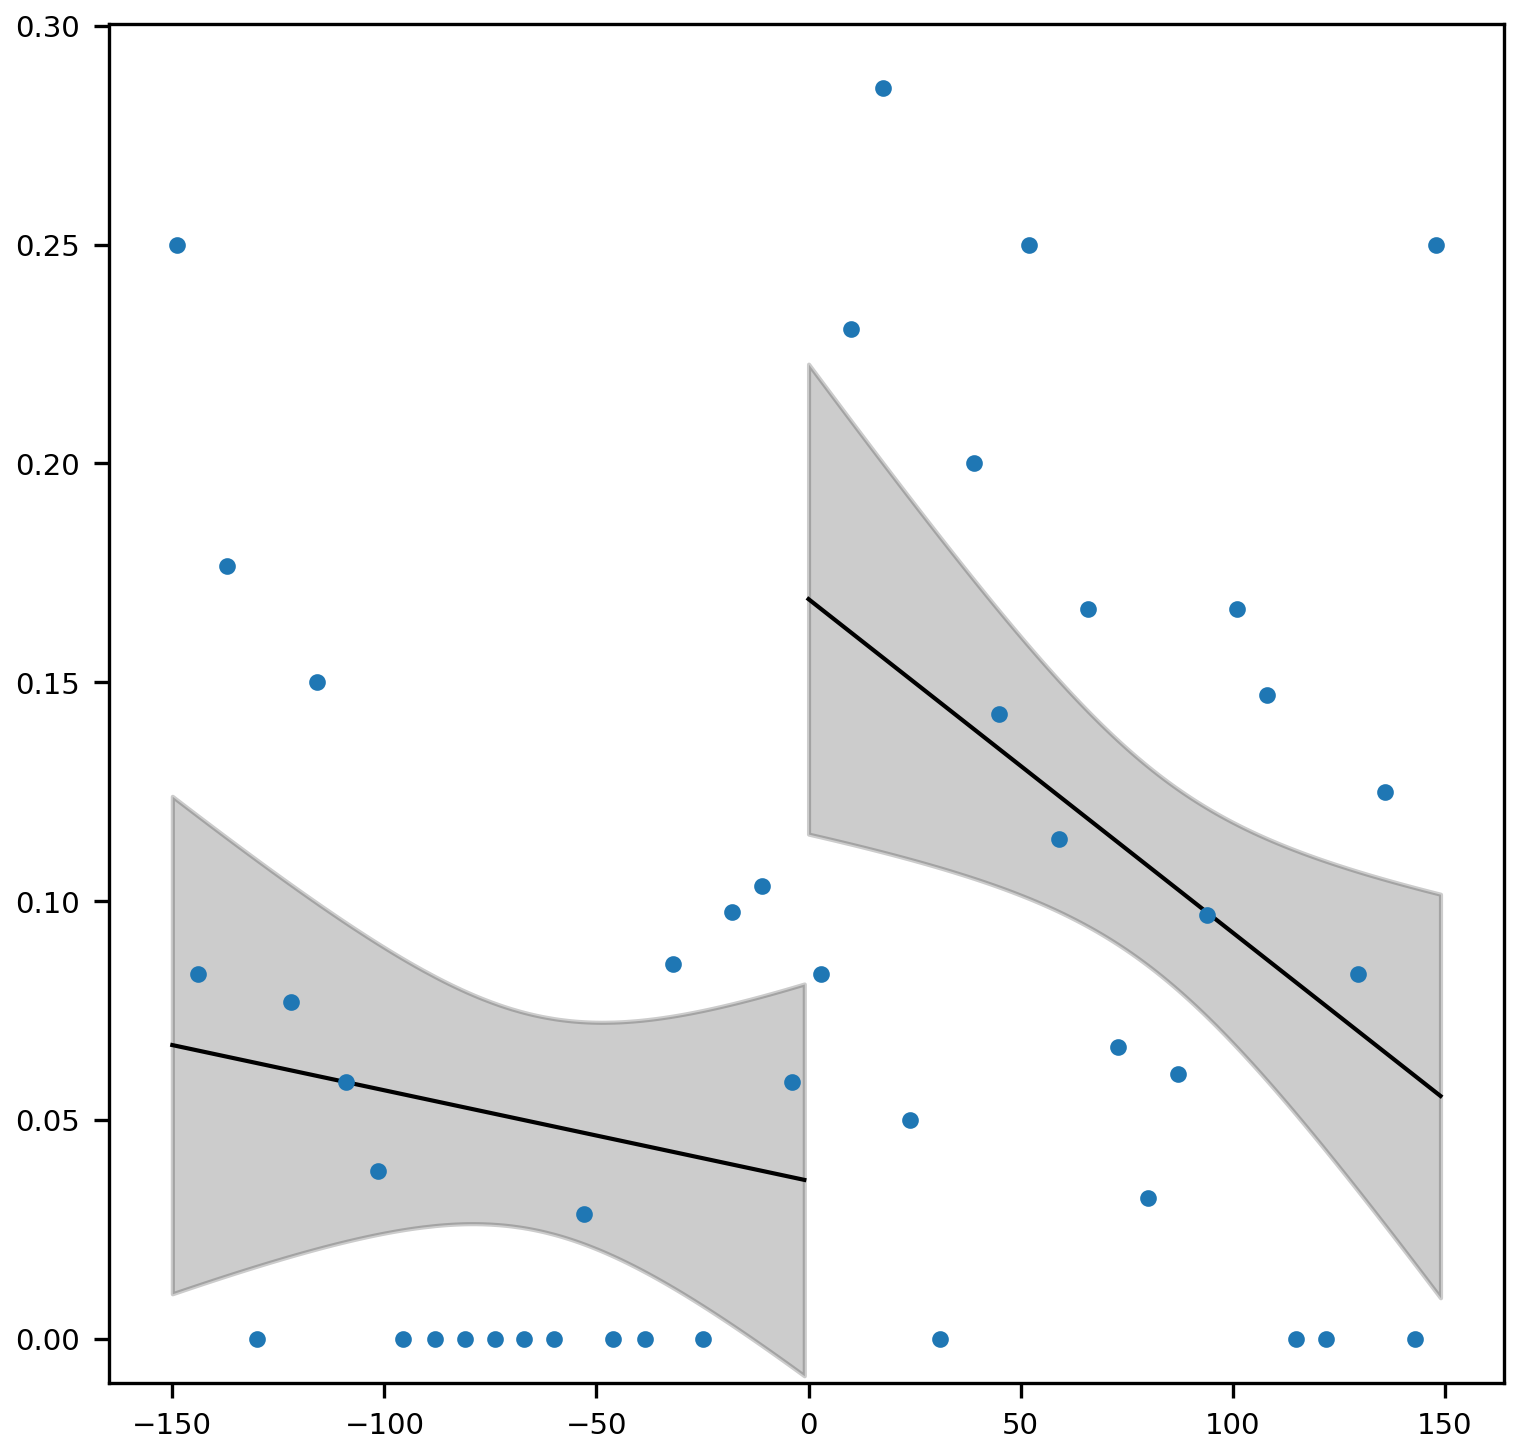

In [ ]:
rdd(date_intro_template, 150, 'CHANGES')

##### Effect of the test checkbox in the PR template

We assume that the `needs: test-suite update` that was introduced within a week of the new checkbox did not have any effect, similarly to the other `needs:` labels. That's why we center the RDD around the introduction of the checkbox in the tempalte. However, strictly speaking, what we are measuring is a combined effect.

We observe that the effect was significant. The estimated effect is that the number of pull requests with tests almost doubled, from 14% to 26%.

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.006    
Dependent Variable: changeTests      AIC:                1288.7295
Date:               2019-09-13 12:11 BIC:                1308.9783
No. Observations:   1167             Log-Likelihood:     -640.36  
Df Model:           3                F-statistic:        3.581    
Df Residuals:       1163             Prob (F-statistic): 0.0135   
R-squared:          0.008            Scale:              0.17605  
------------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
------------------------------------------------------------------
Intercept           0.1393   0.0316  4.4087 0.0000  0.0774  0.2012
afterEvent          0.1494   0.0477  3.1344 0.0017  0.0560  0.2428
reldate            -0.0010   0.0004 -2.4449 0.0145 -0.0019 -0.0002
afterEvent:reldate  0.0005   0.0006  0.9370 0.3488 -0.0006  0.0016
-------------

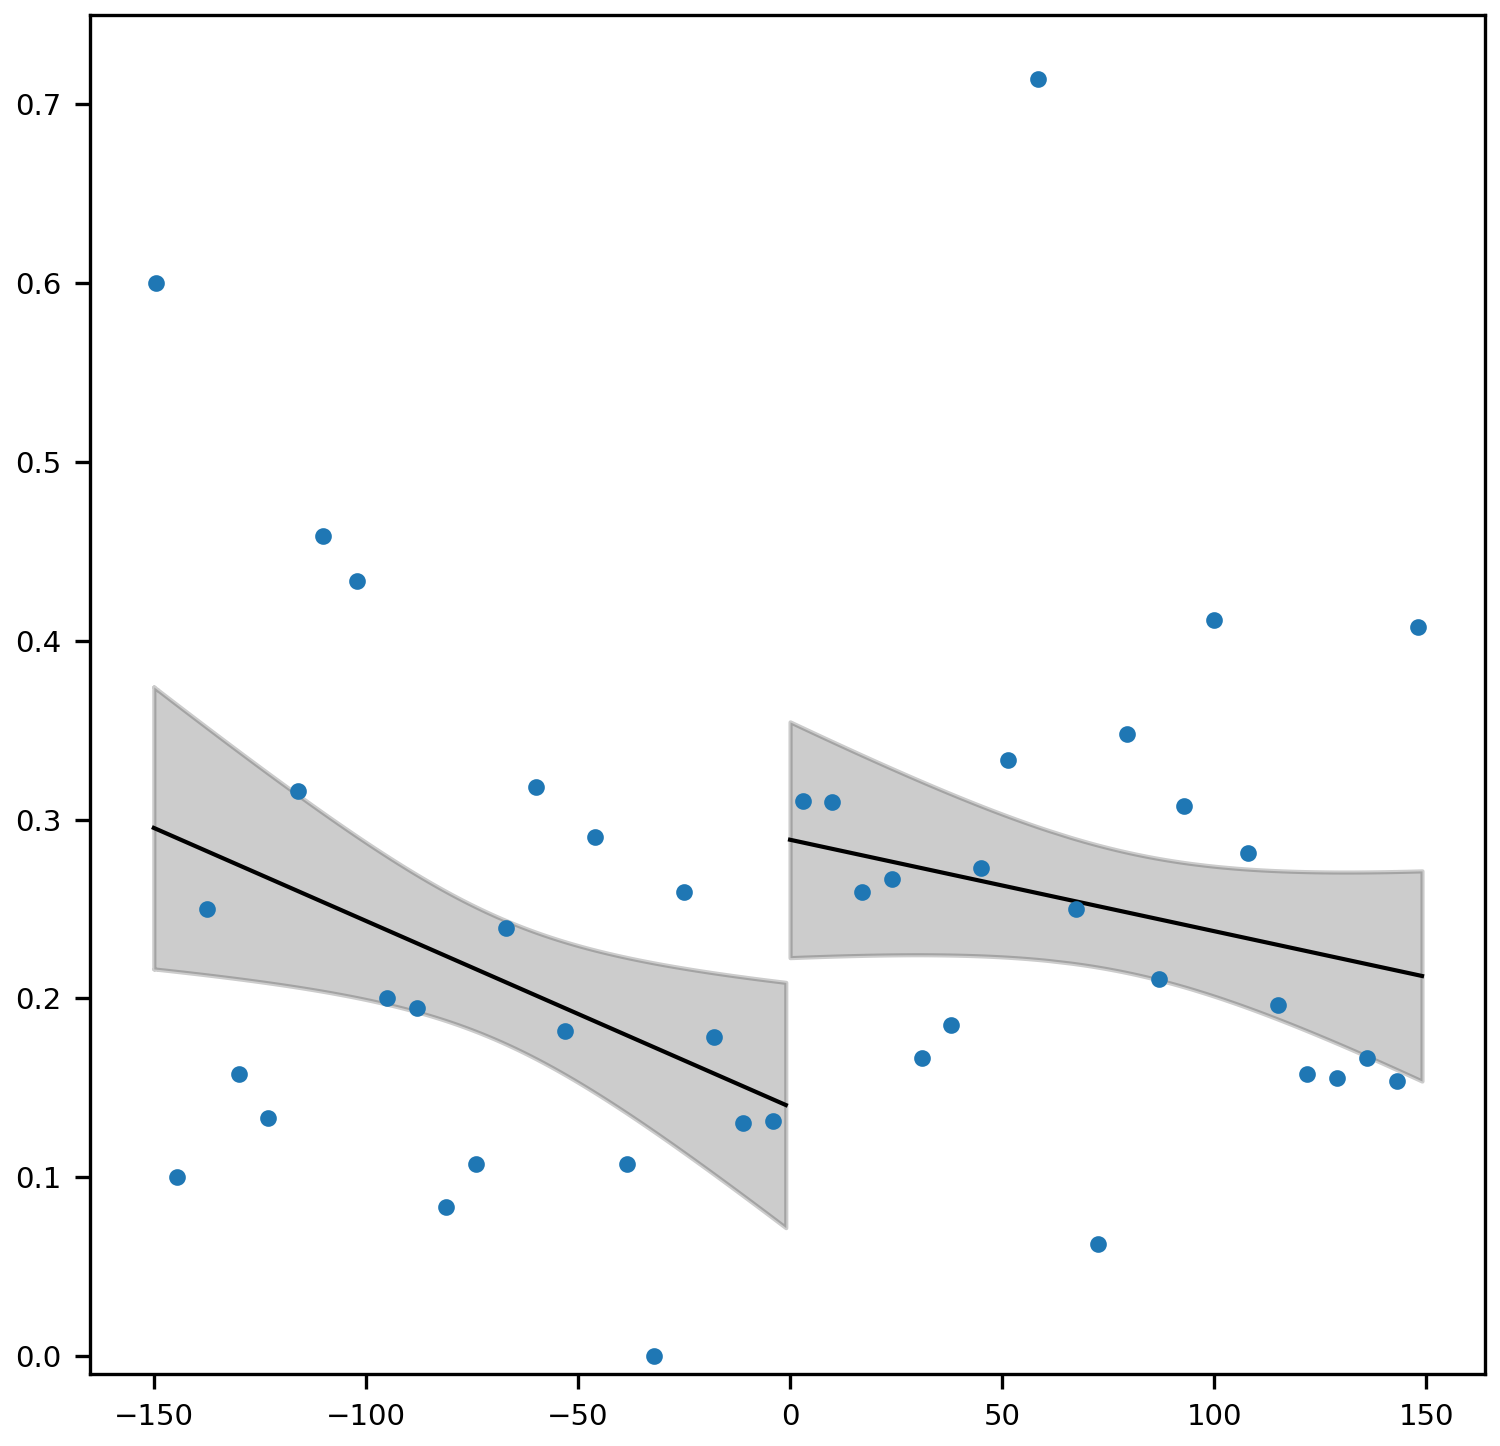

In [ ]:
rdd(date_tests_template, 150, 'Tests')

### Robustness checks: larger bandwidth

For robustness, we test larger bandwidth (450 days before and after the event), with linear and quadratic specifications.

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.006    
Dependent Variable: changeDoc        AIC:                1212.4905
Date:               2019-09-13 12:14 BIC:                1236.0856
No. Observations:   2694             Log-Likelihood:     -602.25  
Df Model:           3                F-statistic:        7.530    
Df Residuals:       2690             Prob (F-statistic): 5.13e-05 
R-squared:          0.007            Scale:              0.091695 
------------------------------------------------------------------
                     Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
------------------------------------------------------------------
Intercept            0.0520   0.0141  3.6752 0.0002  0.0243 0.0797
afterEvent           0.0934   0.0225  4.1459 0.0000  0.0492 0.1375
reldate             -0.0001   0.0001 -1.7864 0.0740 -0.0003 0.0000
afterEvent:reldate   0.0000   0.0001  0.2266 0.8207 -0.0002 0.0002
-------------

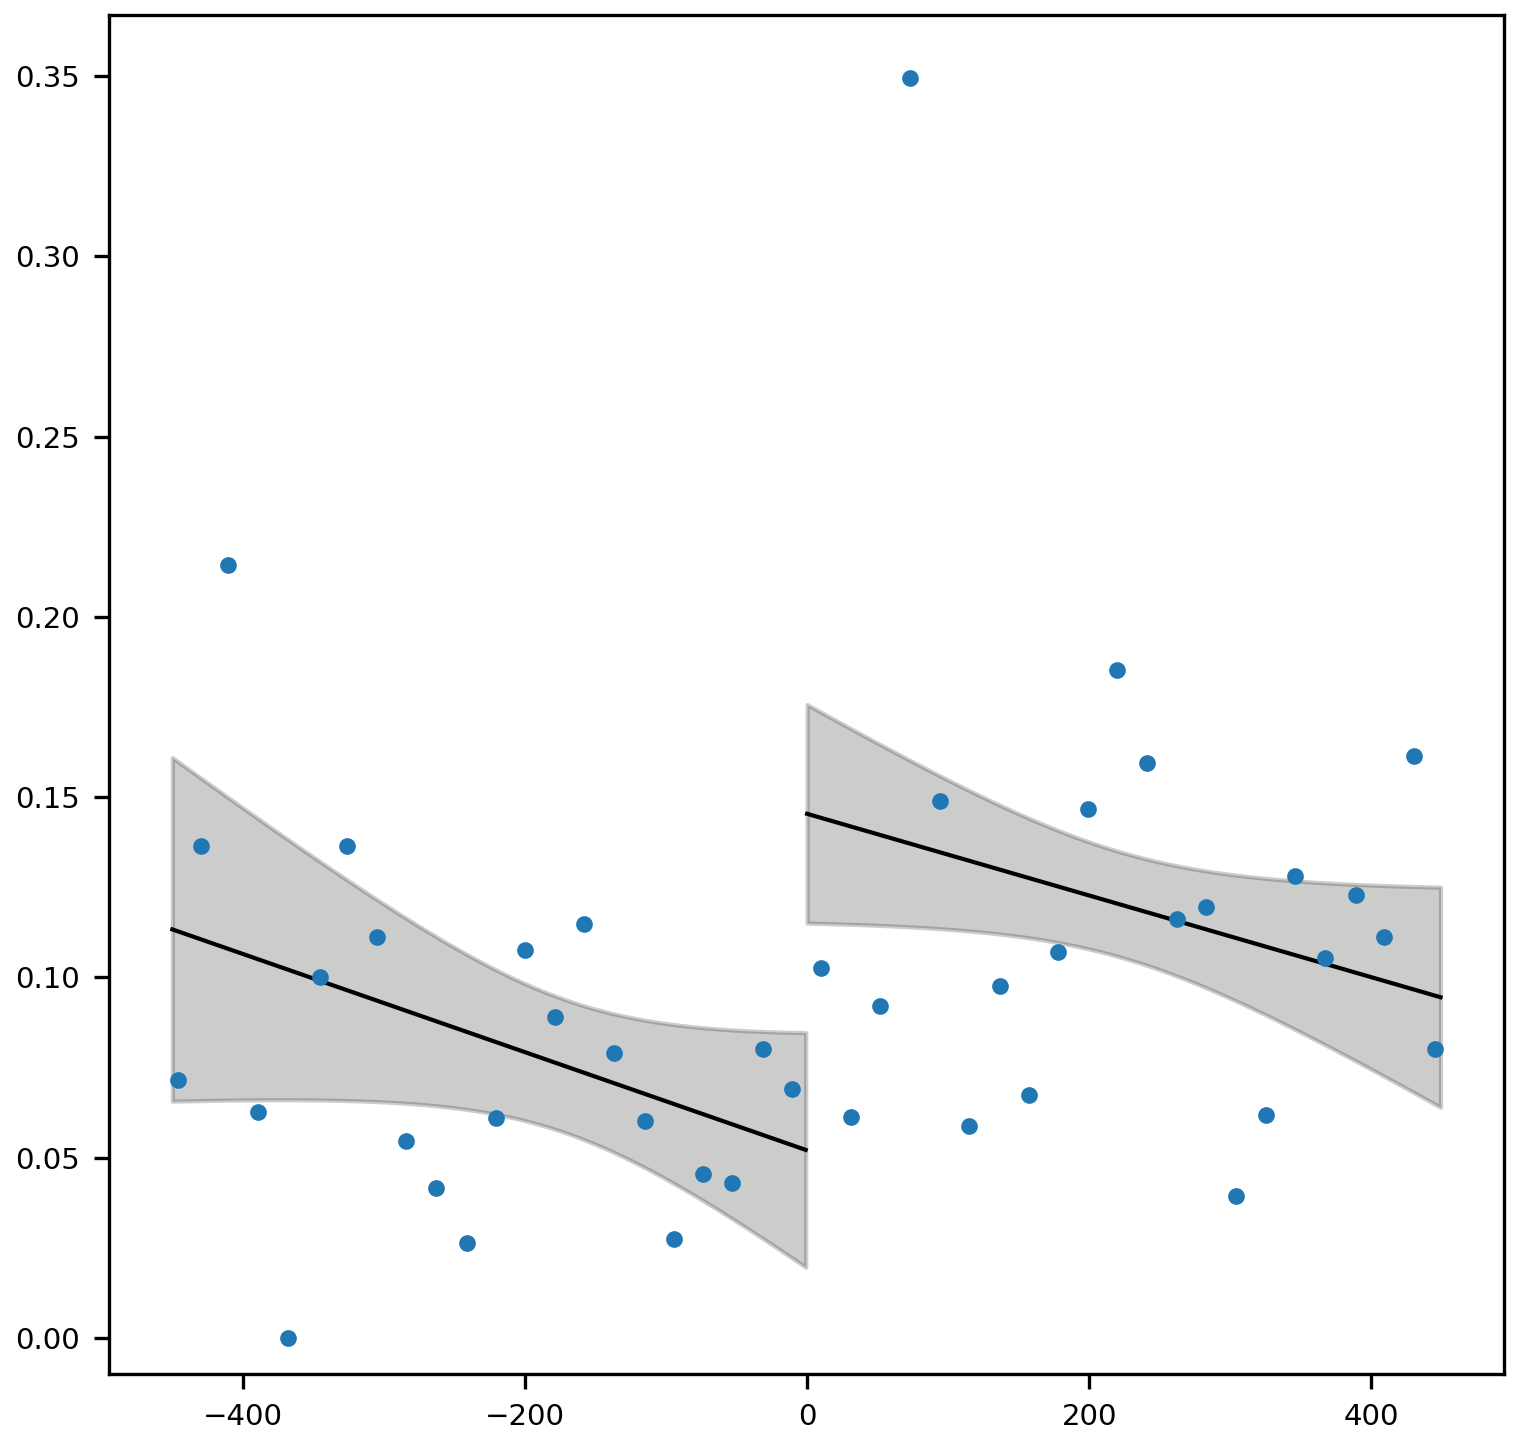

                    Results: Ordinary least squares
Model:                OLS                Adj. R-squared:       0.006    
Dependent Variable:   changeDoc          AIC:                  1214.9281
Date:                 2019-09-13 12:14   BIC:                  1250.3208
No. Observations:     2694               Log-Likelihood:       -601.46  
Df Model:             5                  F-statistic:          4.683    
Df Residuals:         2688               Prob (F-statistic):   0.000292 
R-squared:            0.008              Scale:                0.091710 
------------------------------------------------------------------------
                           Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
------------------------------------------------------------------------
Intercept                  0.0654   0.0189  3.4549 0.0006  0.0283 0.1025
afterEvent                 0.0978   0.0333  2.9411 0.0033  0.0326 0.1630
reldate                    0.0001   0.0002  0.3236 0.7463 -0.0004 0.0005

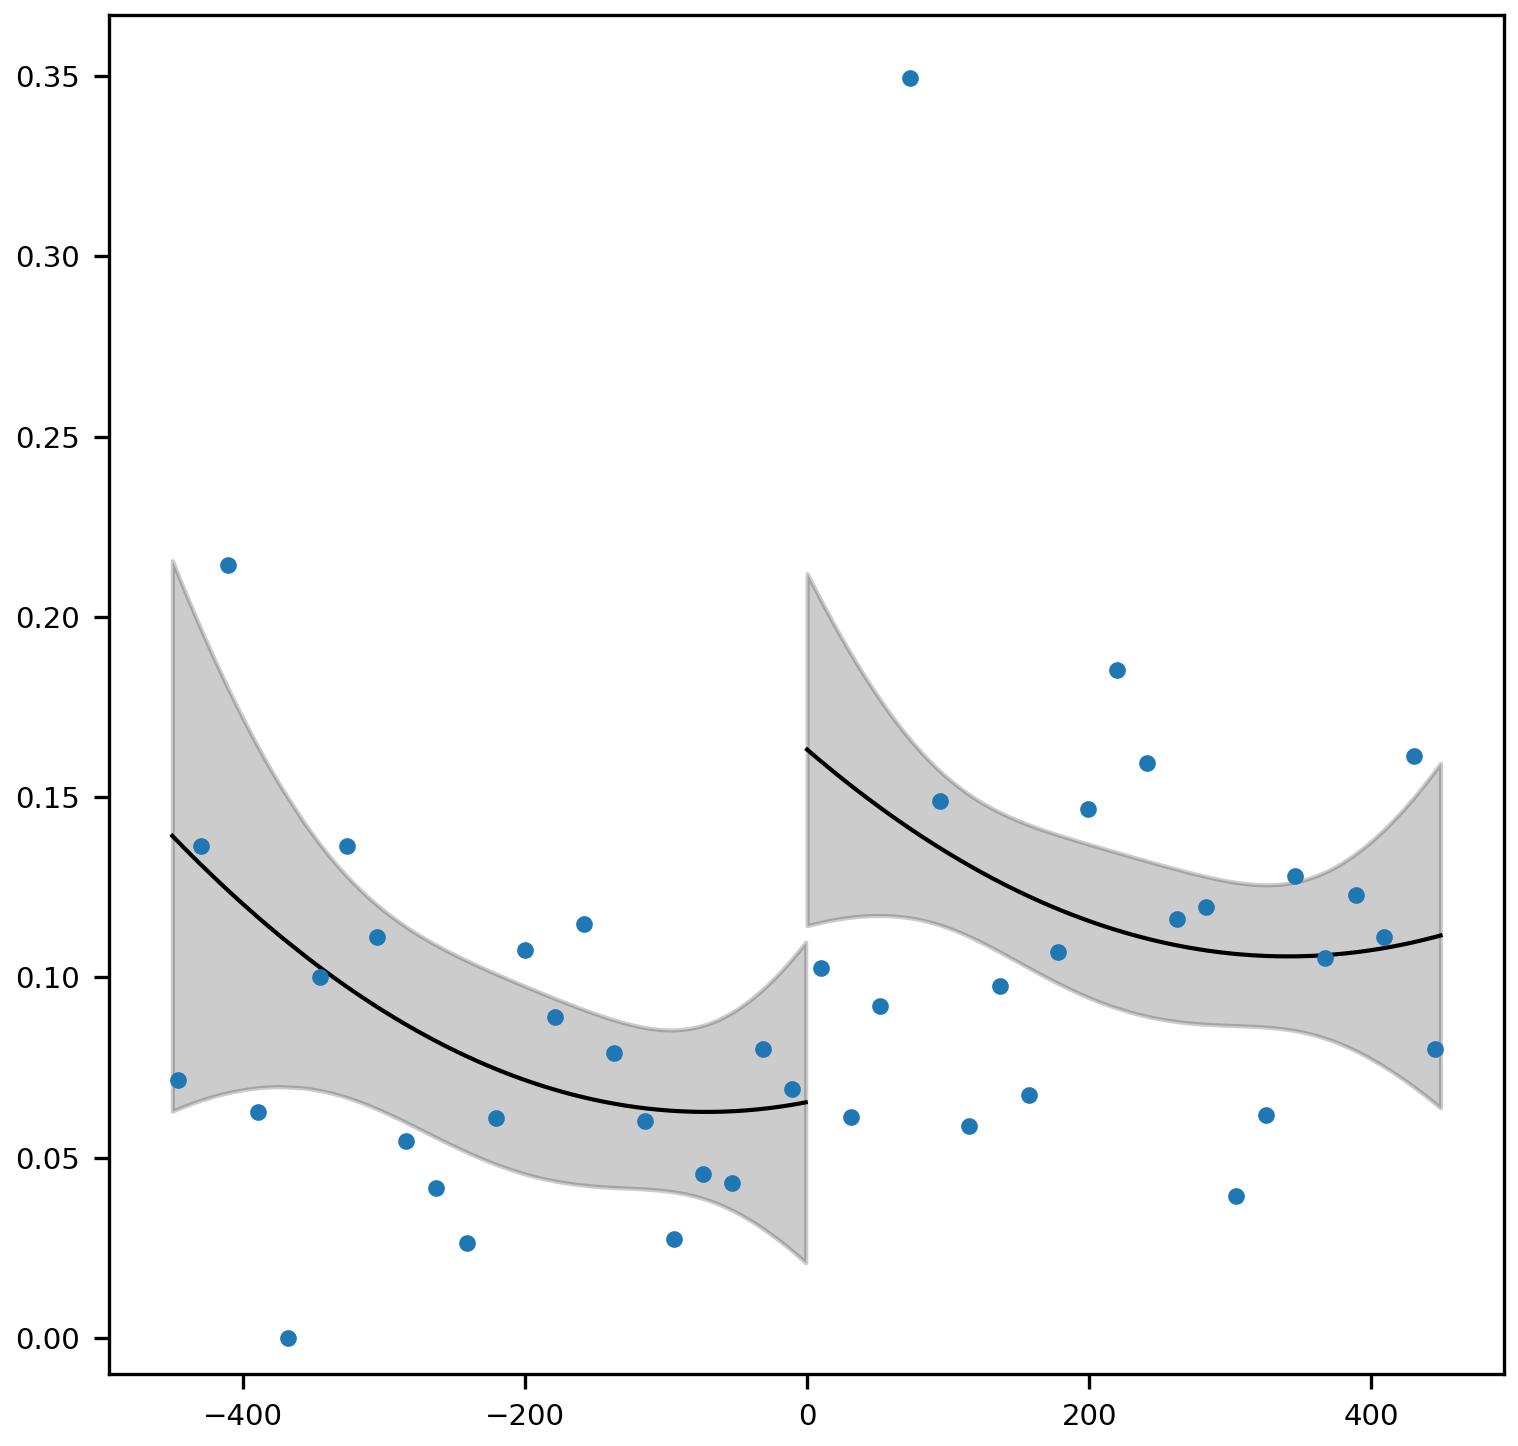

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.008   
Dependent Variable: changeCHANGES    AIC:                660.3797
Date:               2019-09-13 12:14 BIC:                683.9748
No. Observations:   2694             Log-Likelihood:     -326.19 
Df Model:           3                F-statistic:        9.370   
Df Residuals:       2690             Prob (F-statistic): 3.69e-06
R-squared:          0.009            Scale:              0.074703
-----------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
-----------------------------------------------------------------
Intercept           0.0411   0.0123  3.3433 0.0008  0.0170 0.0653
afterEvent          0.0832   0.0202  4.1221 0.0000  0.0437 0.1228
reldate            -0.0001   0.0001 -0.9091 0.3633 -0.0002 0.0001
afterEvent:reldate -0.0000   0.0001 -0.5062 0.6127 -0.0002 0.0001
---------------------------

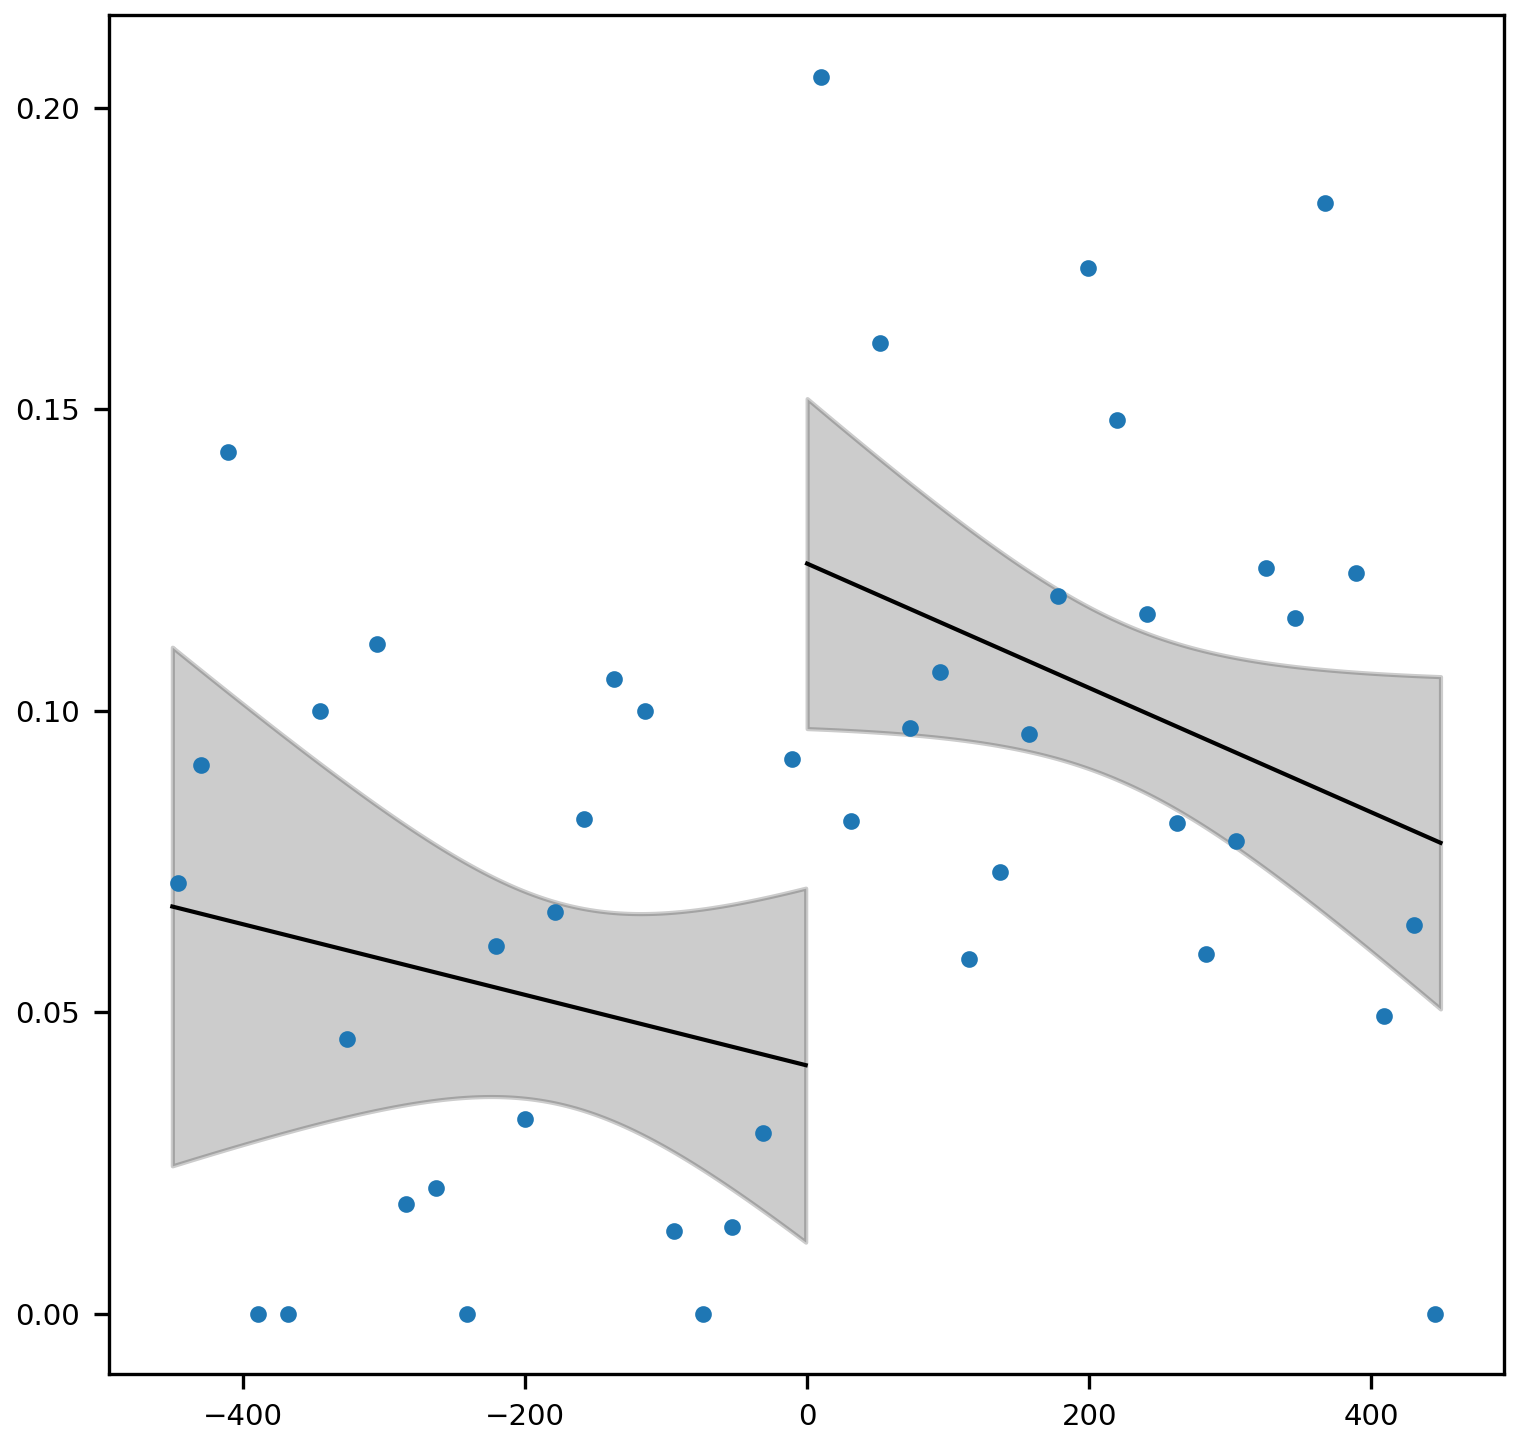

                    Results: Ordinary least squares
Model:                 OLS                Adj. R-squared:       0.008   
Dependent Variable:    changeCHANGES      AIC:                  663.4942
Date:                  2019-09-13 12:14   BIC:                  698.8868
No. Observations:      2694               Log-Likelihood:       -325.75 
Df Model:              5                  F-statistic:          5.909   
Df Residuals:          2688               Prob (F-statistic):   1.93e-05
R-squared:             0.010              Scale:                0.074734
------------------------------------------------------------------------
                           Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
------------------------------------------------------------------------
Intercept                  0.0543   0.0170  3.1921 0.0014  0.0210 0.0876
afterEvent                 0.0674   0.0319  2.1103 0.0348  0.0048 0.1300
reldate                    0.0002   0.0002  0.7205 0.4712 -0.0003 0.0006

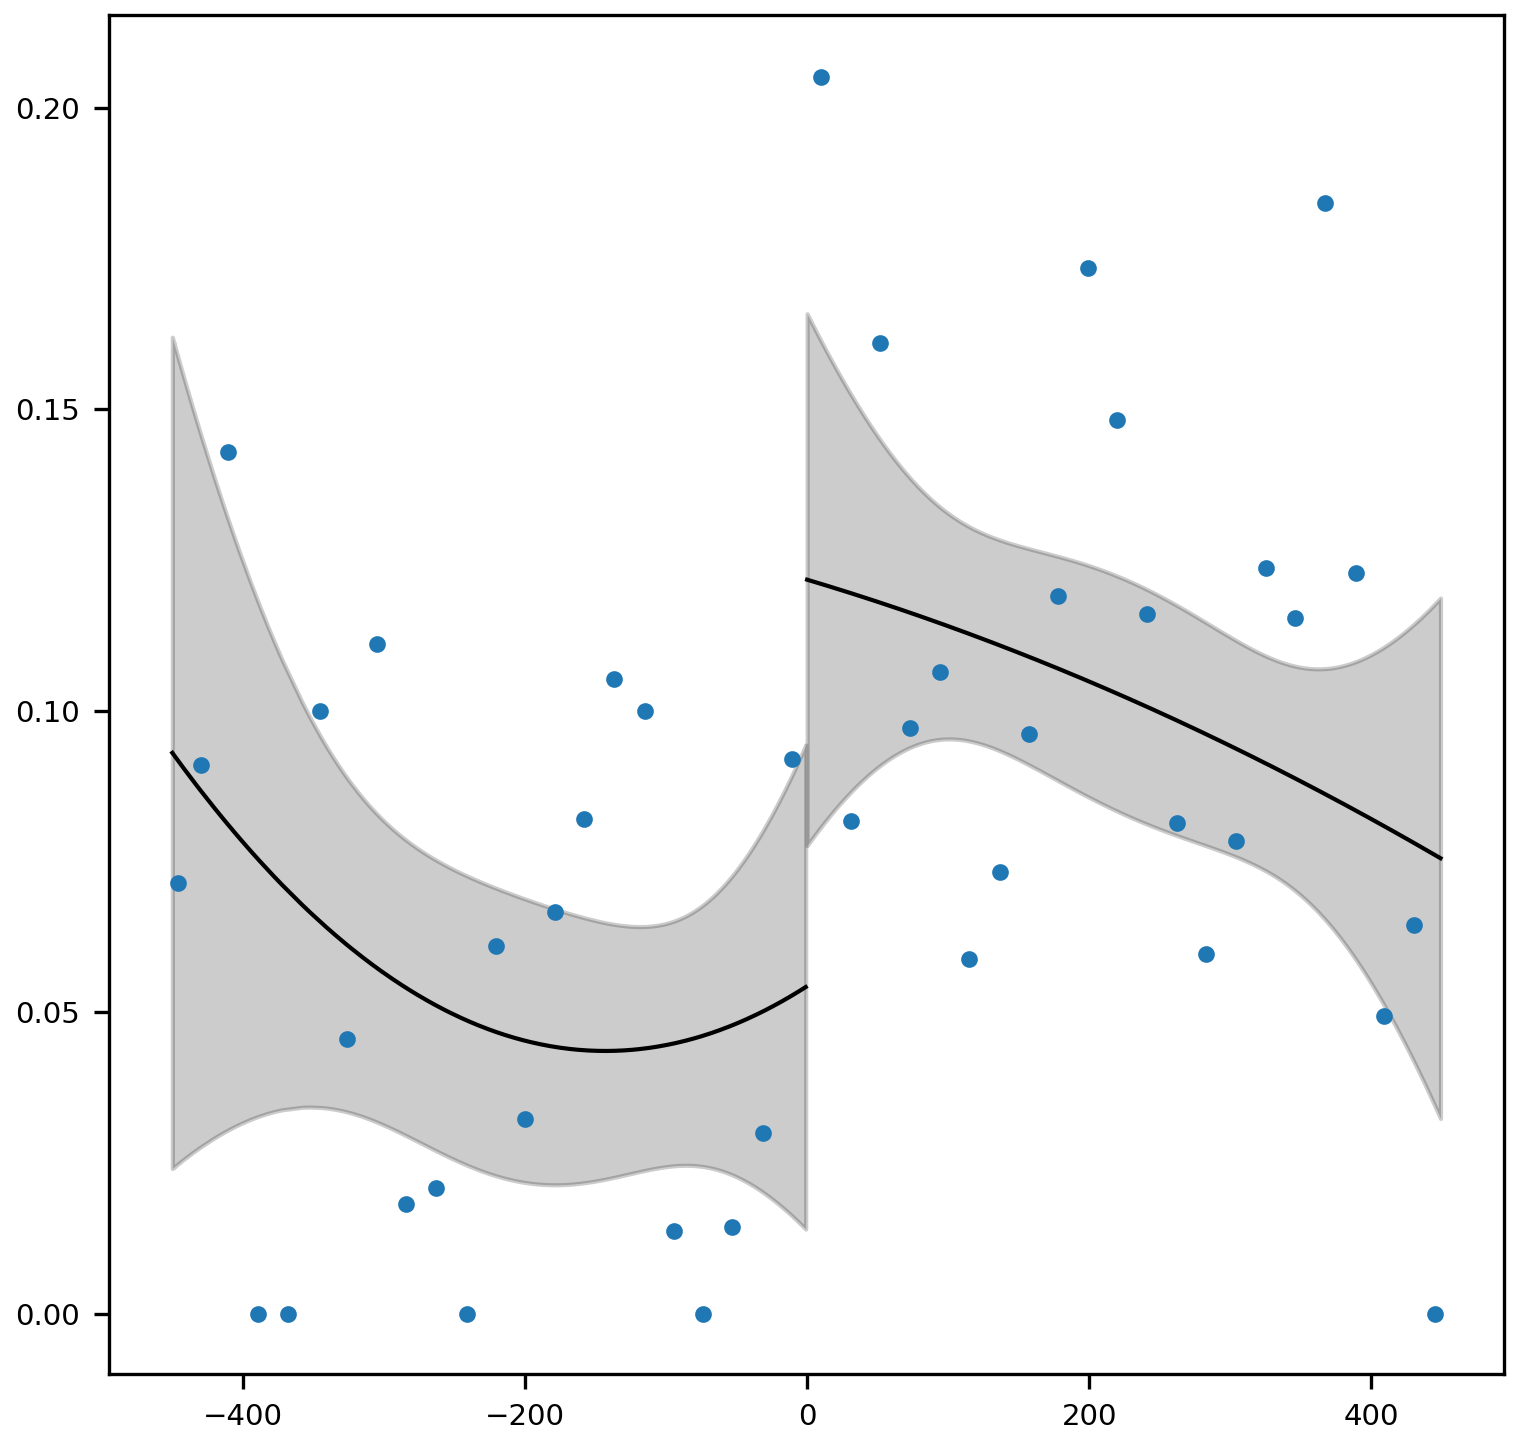

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.004    
Dependent Variable: changeTests      AIC:                3356.4914
Date:               2019-09-13 12:14 BIC:                3380.5342
No. Observations:   3013             Log-Likelihood:     -1674.2  
Df Model:           3                F-statistic:        5.709    
Df Residuals:       3009             Prob (F-statistic): 0.000680 
R-squared:          0.005            Scale:              0.17814  
------------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
------------------------------------------------------------------
Intercept           0.1861   0.0196  9.4913 0.0000  0.1477  0.2245
afterEvent          0.0927   0.0289  3.2104 0.0013  0.0361  0.1492
reldate            -0.0003   0.0001 -2.9641 0.0030 -0.0004 -0.0001
afterEvent:reldate  0.0000   0.0001  0.1203 0.9043 -0.0002  0.0002
-------------

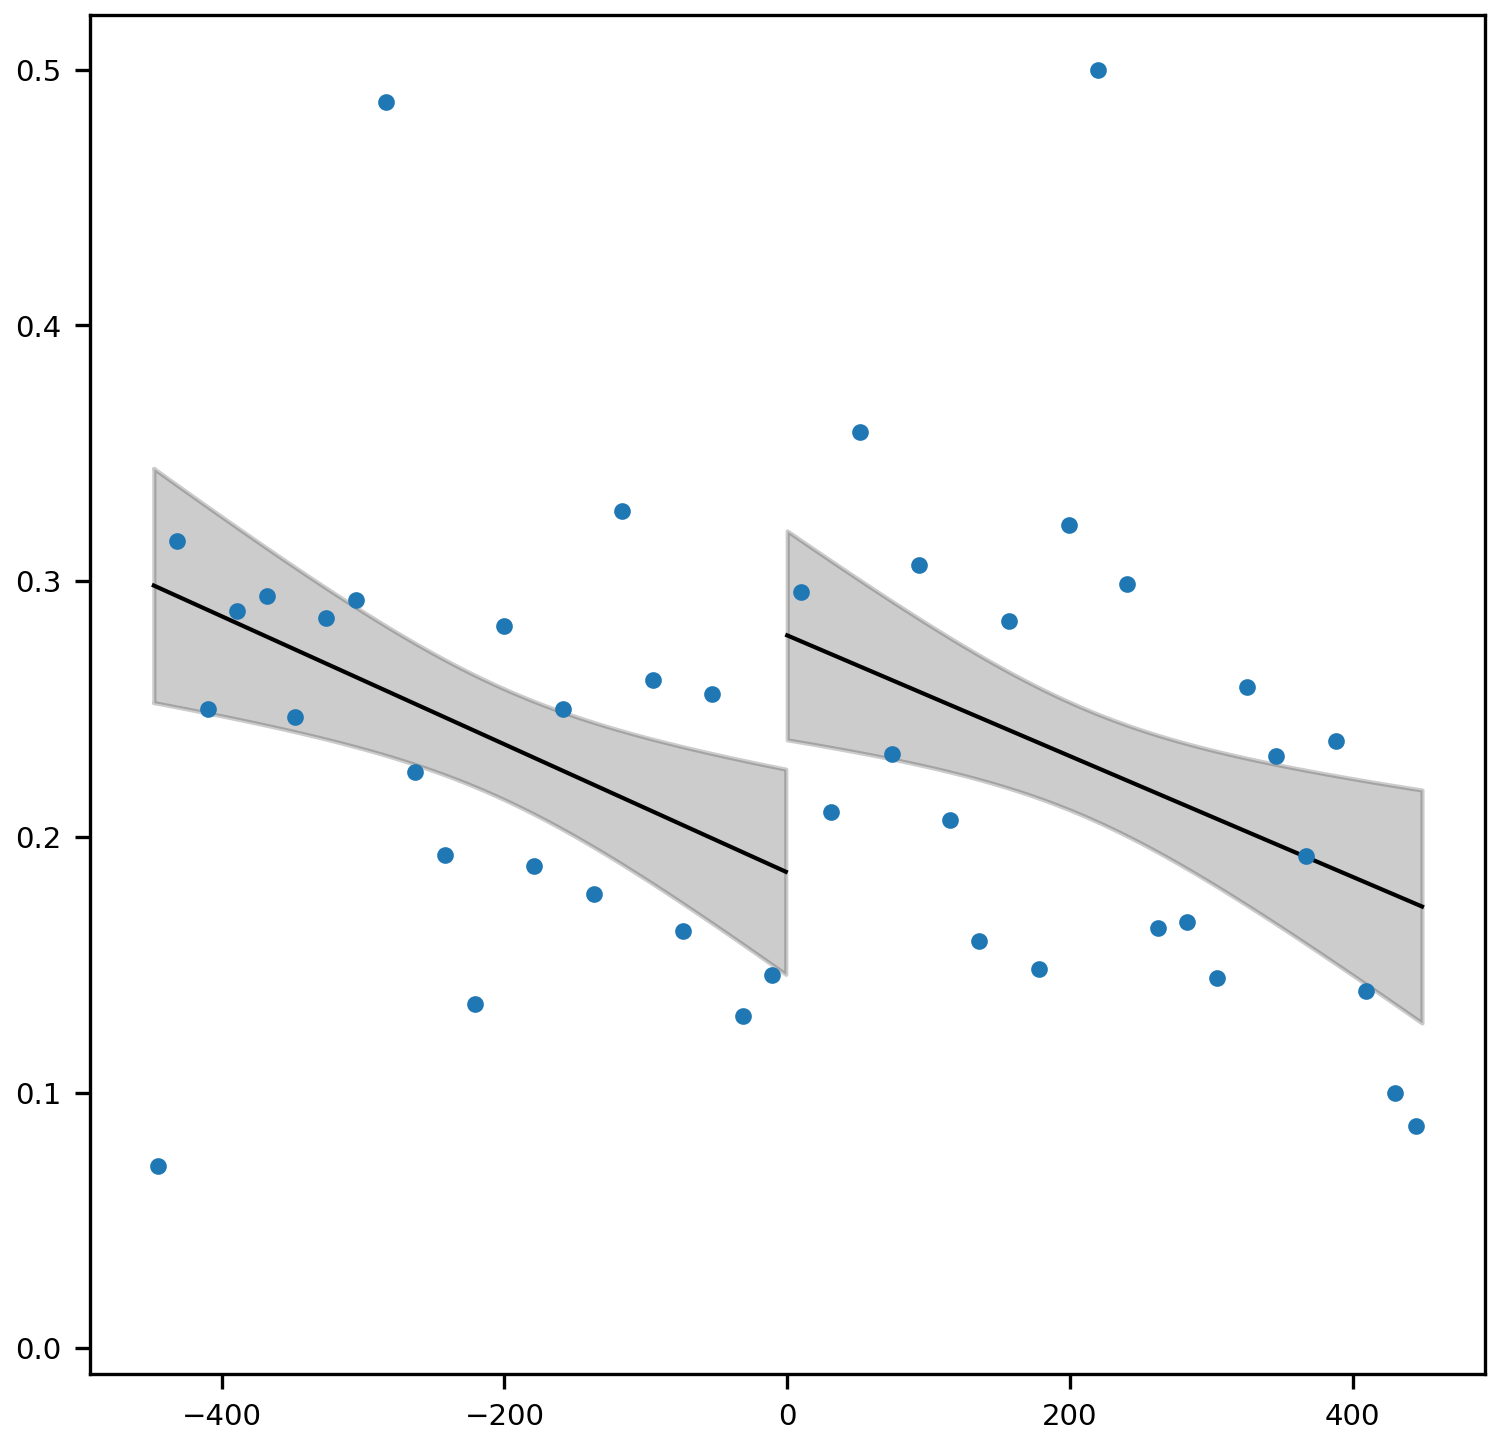

                    Results: Ordinary least squares
Model:                OLS                Adj. R-squared:       0.005    
Dependent Variable:   changeTests        AIC:                  3358.3953
Date:                 2019-09-13 12:14   BIC:                  3394.4595
No. Observations:     3013               Log-Likelihood:       -1673.2  
Df Model:             5                  F-statistic:          4.241    
Df Residuals:         3007               Prob (F-statistic):   0.000761 
R-squared:            0.006              Scale:                0.17813  
------------------------------------------------------------------------
                           Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
------------------------------------------------------------------------
Intercept                  0.1632   0.0277  5.8929 0.0000  0.1089 0.2174
afterEvent                 0.0921   0.0425  2.1671 0.0302  0.0088 0.1754
reldate                   -0.0006   0.0003 -1.8291 0.0674 -0.0012 0.0000

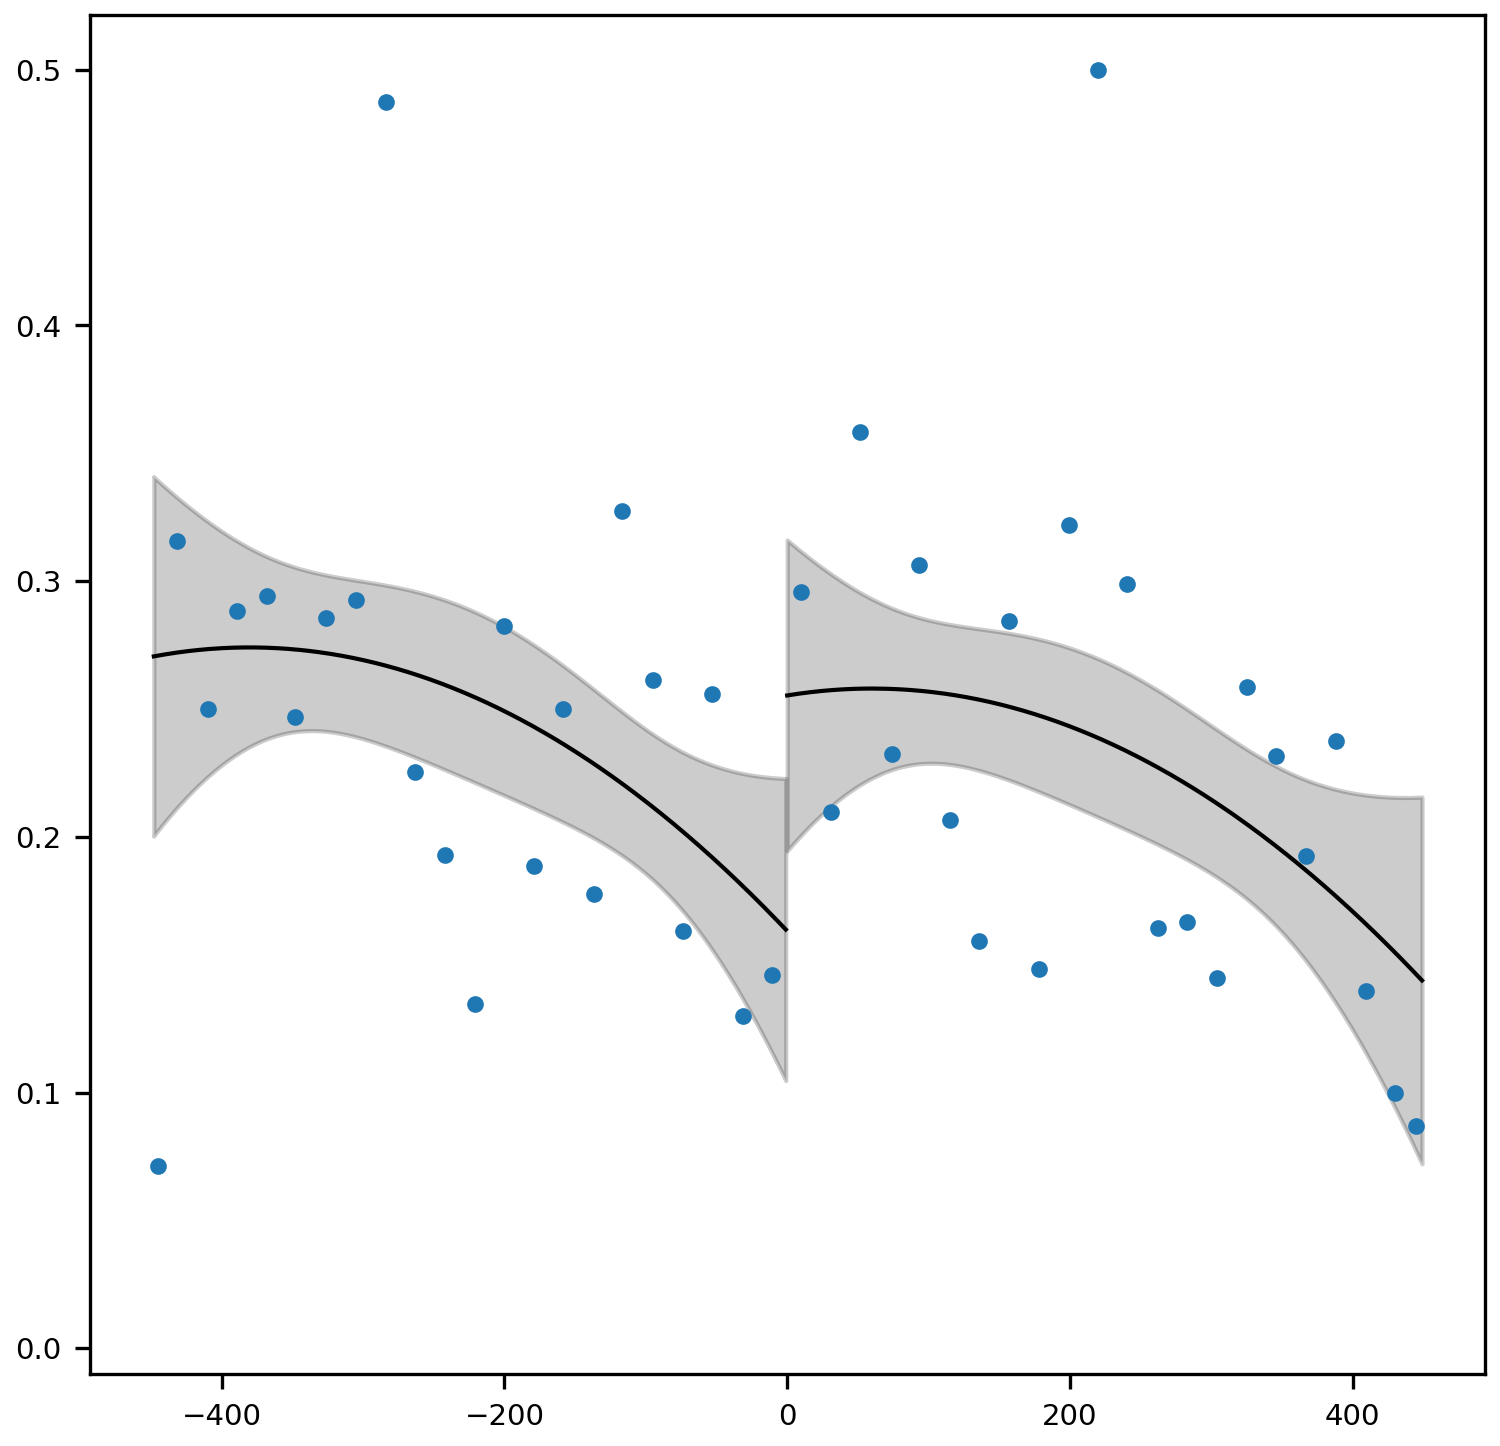

In [ ]:
for variable, date in [('Doc', date_intro_template), ('CHANGES', date_intro_template), ('Tests', date_tests_template)]:
    for degree in [1, 2]:
        rdd(date, 450, variable, values, 21, degree=degree)

### Robustness checks: only merged pull requests

In [ ]:
merged_prs = values[values['merged']]

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.014   
Dependent Variable: changeDoc        AIC:                409.3044
Date:               2019-09-13 12:21 BIC:                428.3876
No. Observations:   872              Log-Likelihood:     -200.65 
Df Model:           3                F-statistic:        5.377   
Df Residuals:       868              Prob (F-statistic): 0.00114 
R-squared:          0.017            Scale:              0.093194
-----------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
-----------------------------------------------------------------
Intercept           0.0615   0.0237  2.5988 0.0094  0.0151 0.1079
afterEvent          0.0867   0.0399  2.1748 0.0296  0.0086 0.1649
reldate             0.0000   0.0003  0.0143 0.9886 -0.0006 0.0006
afterEvent:reldate -0.0001   0.0005 -0.1835 0.8544 -0.0010 0.0008
---------------------------

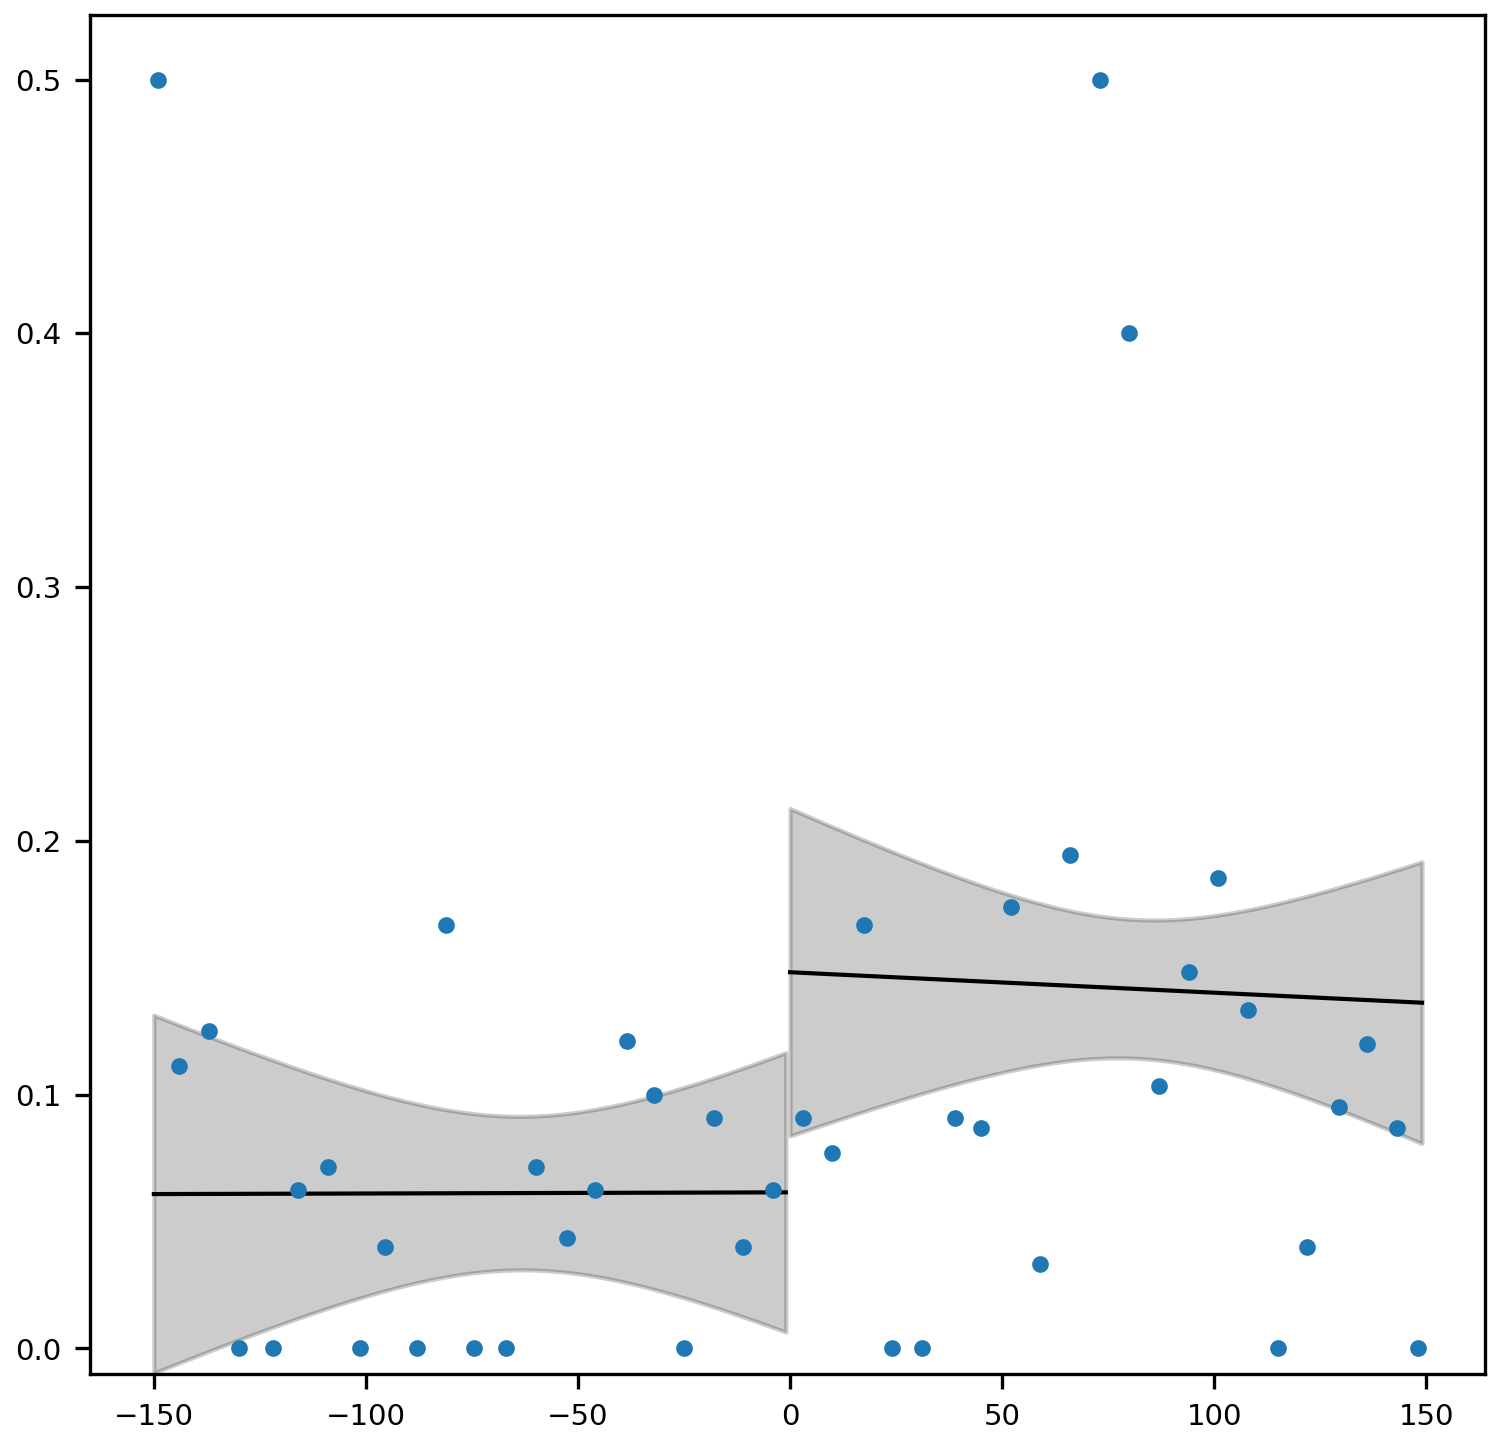

In [ ]:
rdd(date_intro_template, 150, 'Doc', merged_prs)

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.010   
Dependent Variable: changeCHANGES    AIC:                126.8830
Date:               2019-09-13 12:21 BIC:                145.9662
No. Observations:   872              Log-Likelihood:     -59.442 
Df Model:           3                F-statistic:        3.368   
Df Residuals:       868              Prob (F-statistic): 0.0181  
R-squared:          0.013            Scale:              0.067411
-----------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
-----------------------------------------------------------------
Intercept           0.0391   0.0234  1.6658 0.0957 -0.0069 0.0850
afterEvent          0.1050   0.0419  2.5037 0.0123  0.0228 0.1872
reldate            -0.0001   0.0003 -0.3179 0.7506 -0.0008 0.0006
afterEvent:reldate -0.0005   0.0005 -0.9731 0.3305 -0.0015 0.0005
---------------------------

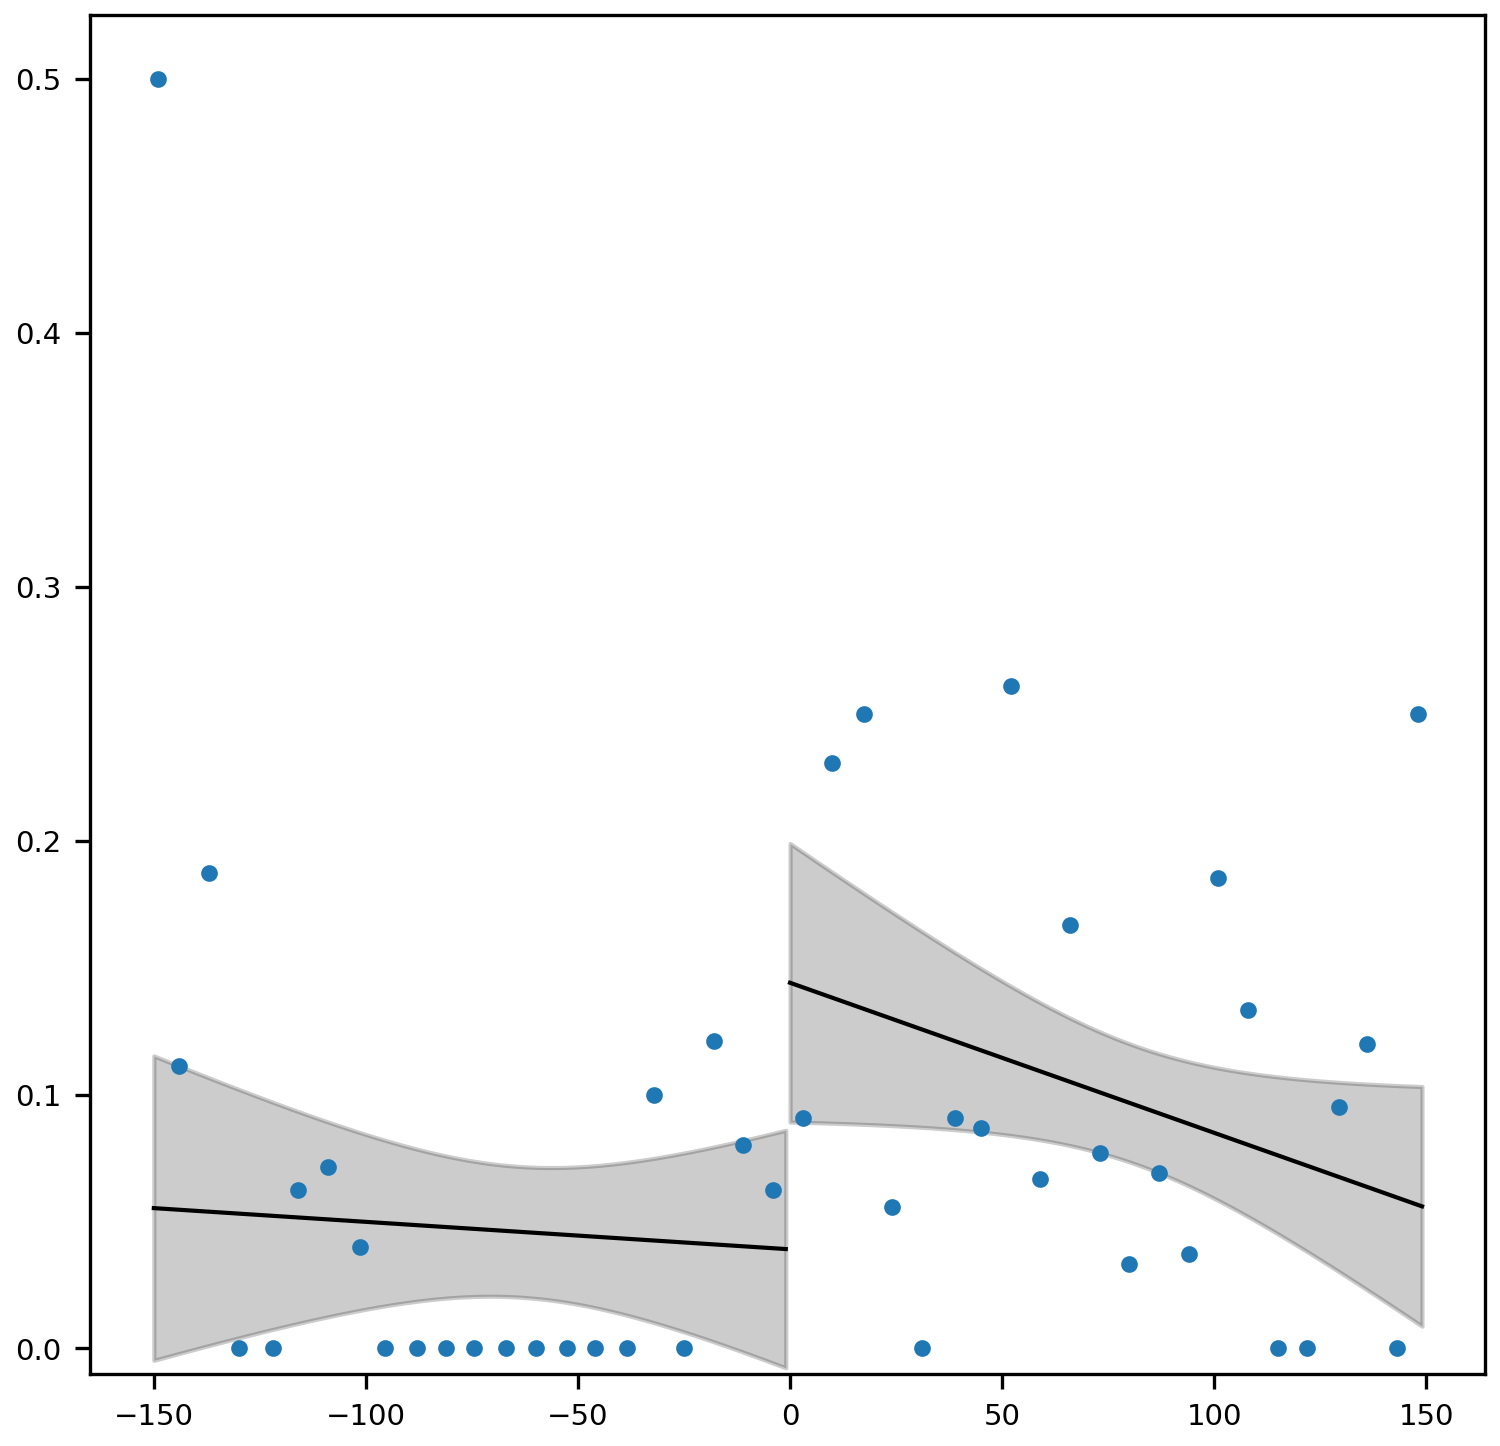

In [ ]:
rdd(date_intro_template, 150, 'CHANGES', merged_prs)

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.003    
Dependent Variable: changeTests      AIC:                1070.9941
Date:               2019-09-13 12:21 BIC:                1090.6689
No. Observations:   1011             Log-Likelihood:     -531.50  
Df Model:           3                F-statistic:        2.255    
Df Residuals:       1007             Prob (F-statistic): 0.0805   
R-squared:          0.006            Scale:              0.16822  
------------------------------------------------------------------
                     Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
------------------------------------------------------------------
Intercept            0.1365   0.0338  4.0449 0.0001  0.0704 0.2027
afterEvent           0.1209   0.0504  2.4001 0.0164  0.0222 0.2196
reldate             -0.0009   0.0005 -1.9085 0.0563 -0.0017 0.0000
afterEvent:reldate   0.0006   0.0006  0.9182 0.3585 -0.0006 0.0017
-------------

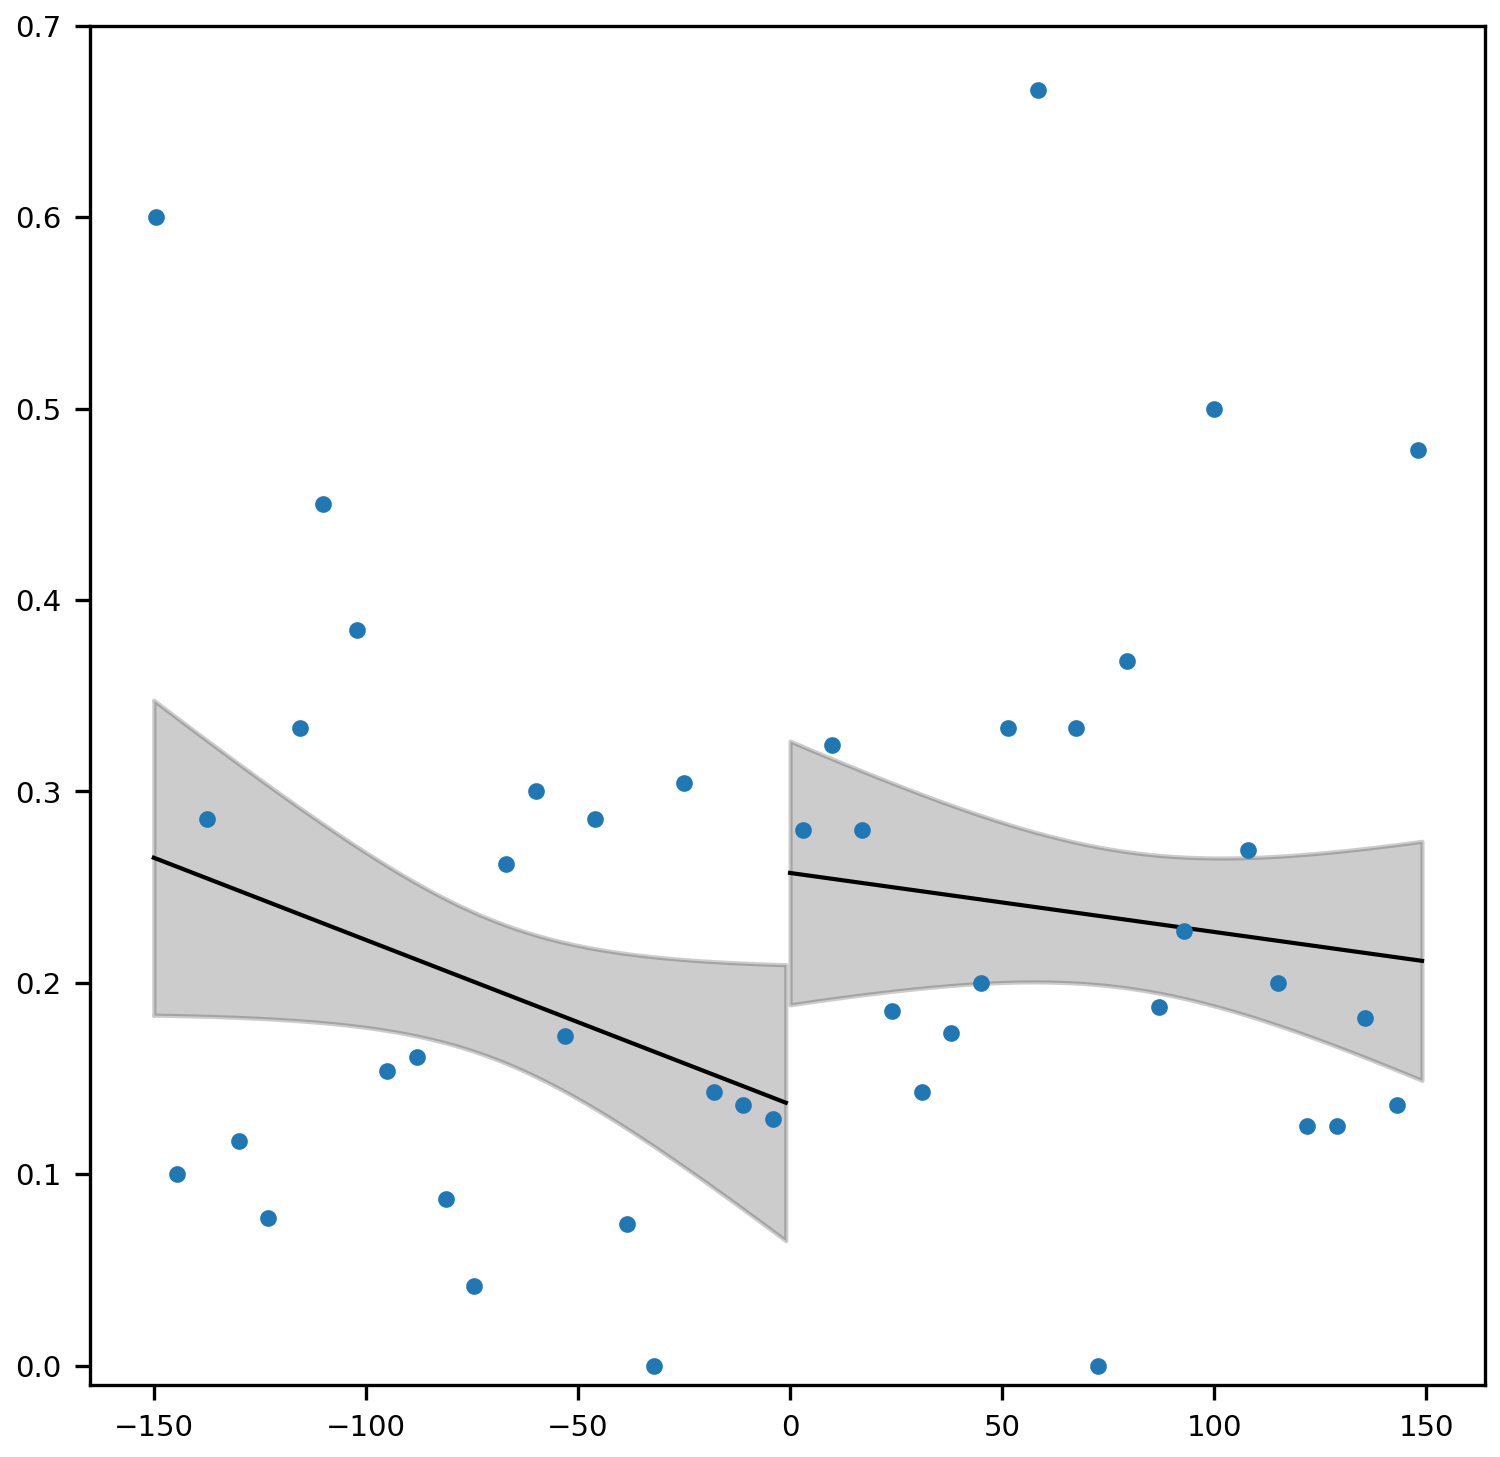

In [ ]:
rdd(date_tests_template, 150, 'Tests', merged_prs)

### Heterogeneous effects

#### Effect on feature pull requests

In principle, these are the pull requests that are most likely to require a documentation + `CHANGES` + test-suite update.

In [ ]:
features = values[values['feature']]
len(features) / len(values)

0.06033010813887308

We observe that the introduction of the template had a very large effect on the number of feature pull requests with an update to the `CHANGES` file (the estimated value of the jump is 50%).
The small number of observations is compensated by the size of the effect, and it is statistically significant.

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.103   
Dependent Variable: changeCHANGES    AIC:                96.8514 
Date:               2019-09-13 12:22 BIC:                105.7878
No. Observations:   69               Log-Likelihood:     -44.426 
Df Model:           3                F-statistic:        3.582   
Df Residuals:       65               Prob (F-statistic): 0.0184  
R-squared:          0.142            Scale:              0.22527 
-----------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
-----------------------------------------------------------------
Intercept           0.1459   0.1626  0.8975 0.3695 -0.1728 0.4646
afterEvent          0.6334   0.2348  2.6973 0.0070  0.1732 1.0937
reldate            -0.0020   0.0021 -0.9655 0.3343 -0.0061 0.0021
afterEvent:reldate -0.0005   0.0031 -0.1529 0.8785 -0.0066 0.0056
---------------------------

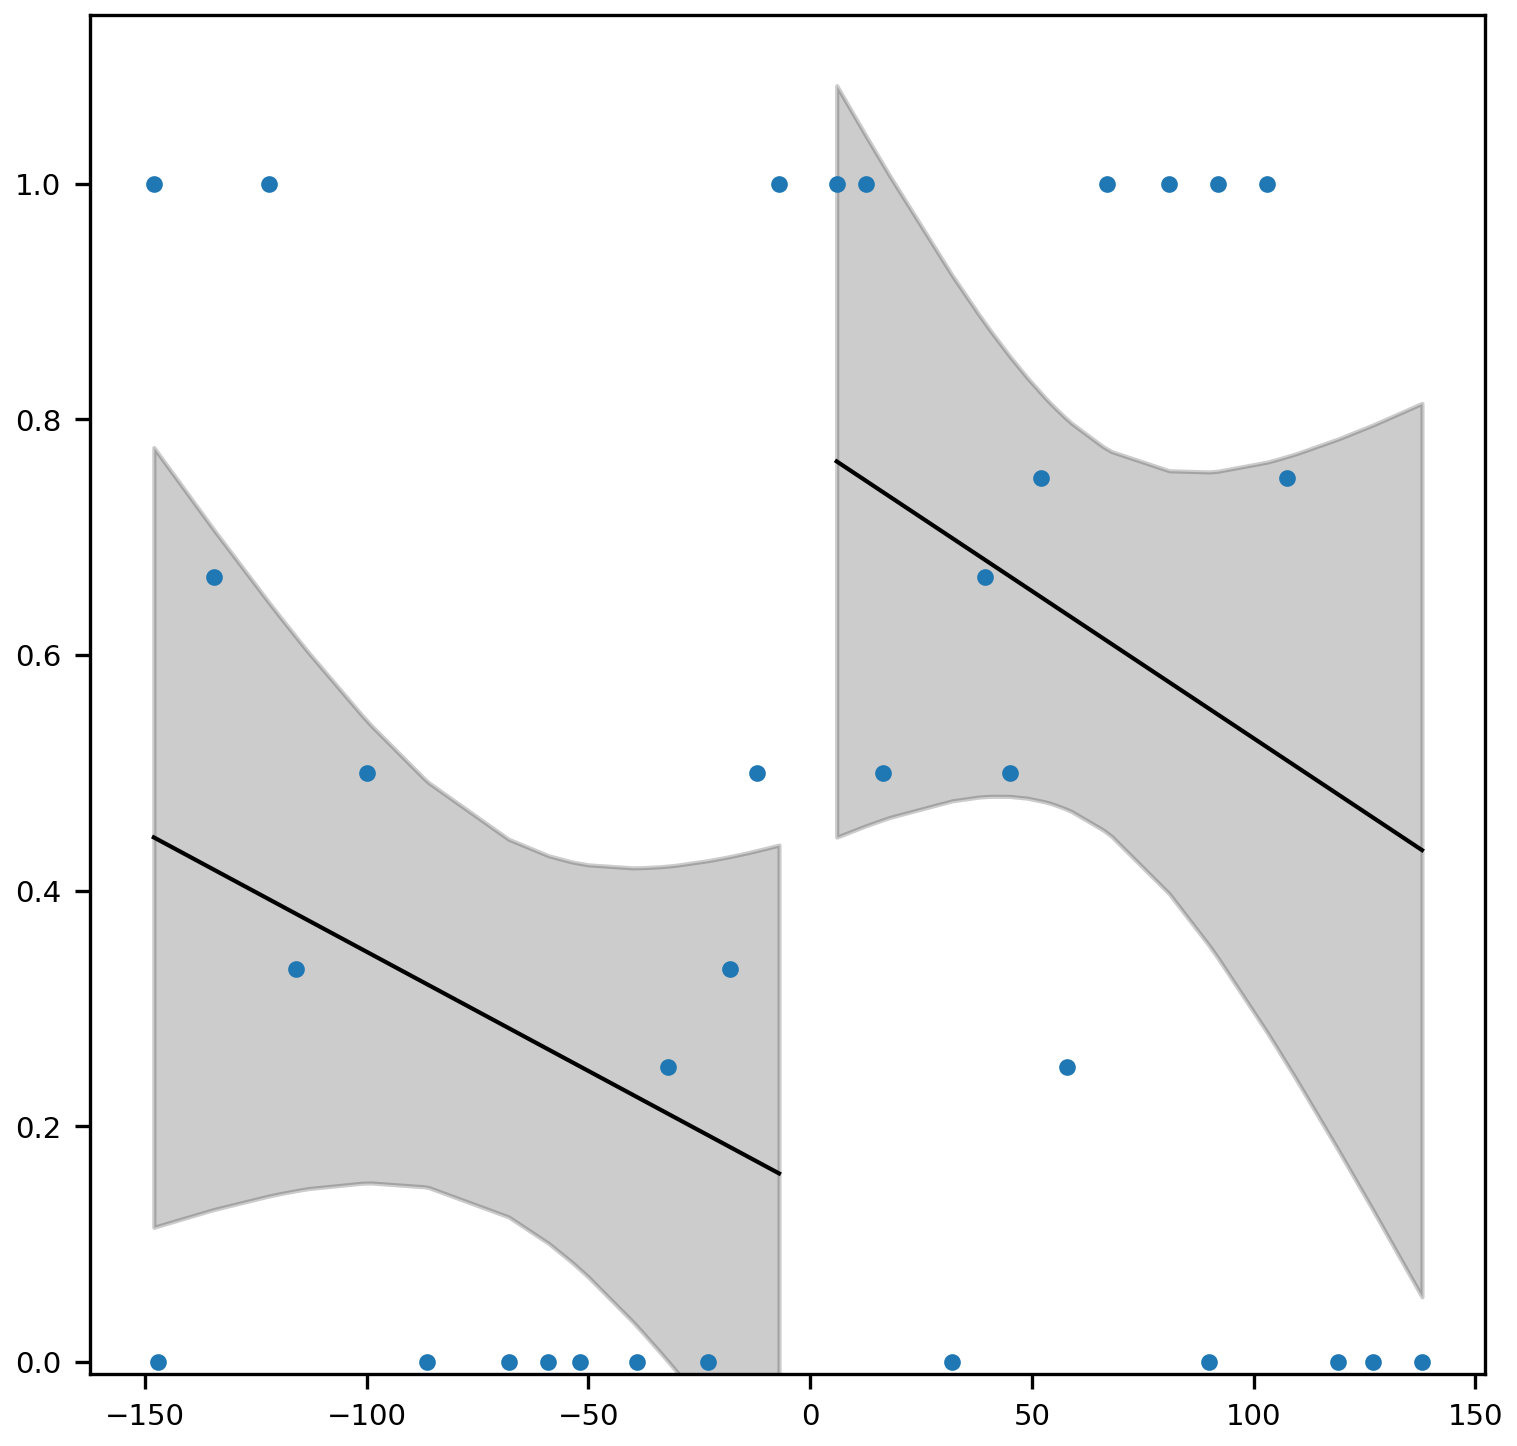

In [ ]:
rdd(date_intro_template, 150, 'CHANGES', features)

                 Results: Ordinary least squares
Model:               OLS              Adj. R-squared:     0.118   
Dependent Variable:  changeCHANGES    AIC:                216.5566
Date:                2019-09-13 12:22 BIC:                229.0762
No. Observations:    169              Log-Likelihood:     -104.28 
Df Model:            3                F-statistic:        8.897   
Df Residuals:        165              Prob (F-statistic): 1.69e-05
R-squared:           0.134            Scale:              0.20600 
------------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
------------------------------------------------------------------
Intercept           0.2923   0.0892  3.2782 0.0010  0.1176  0.4671
afterEvent          0.4115   0.1328  3.0981 0.0019  0.1512  0.6718
reldate             0.0004   0.0004  1.1229 0.2615 -0.0003  0.0012
afterEvent:reldate -0.0014   0.0006 -2.4189 0.0156 -0.0025 -0.0003
-------------

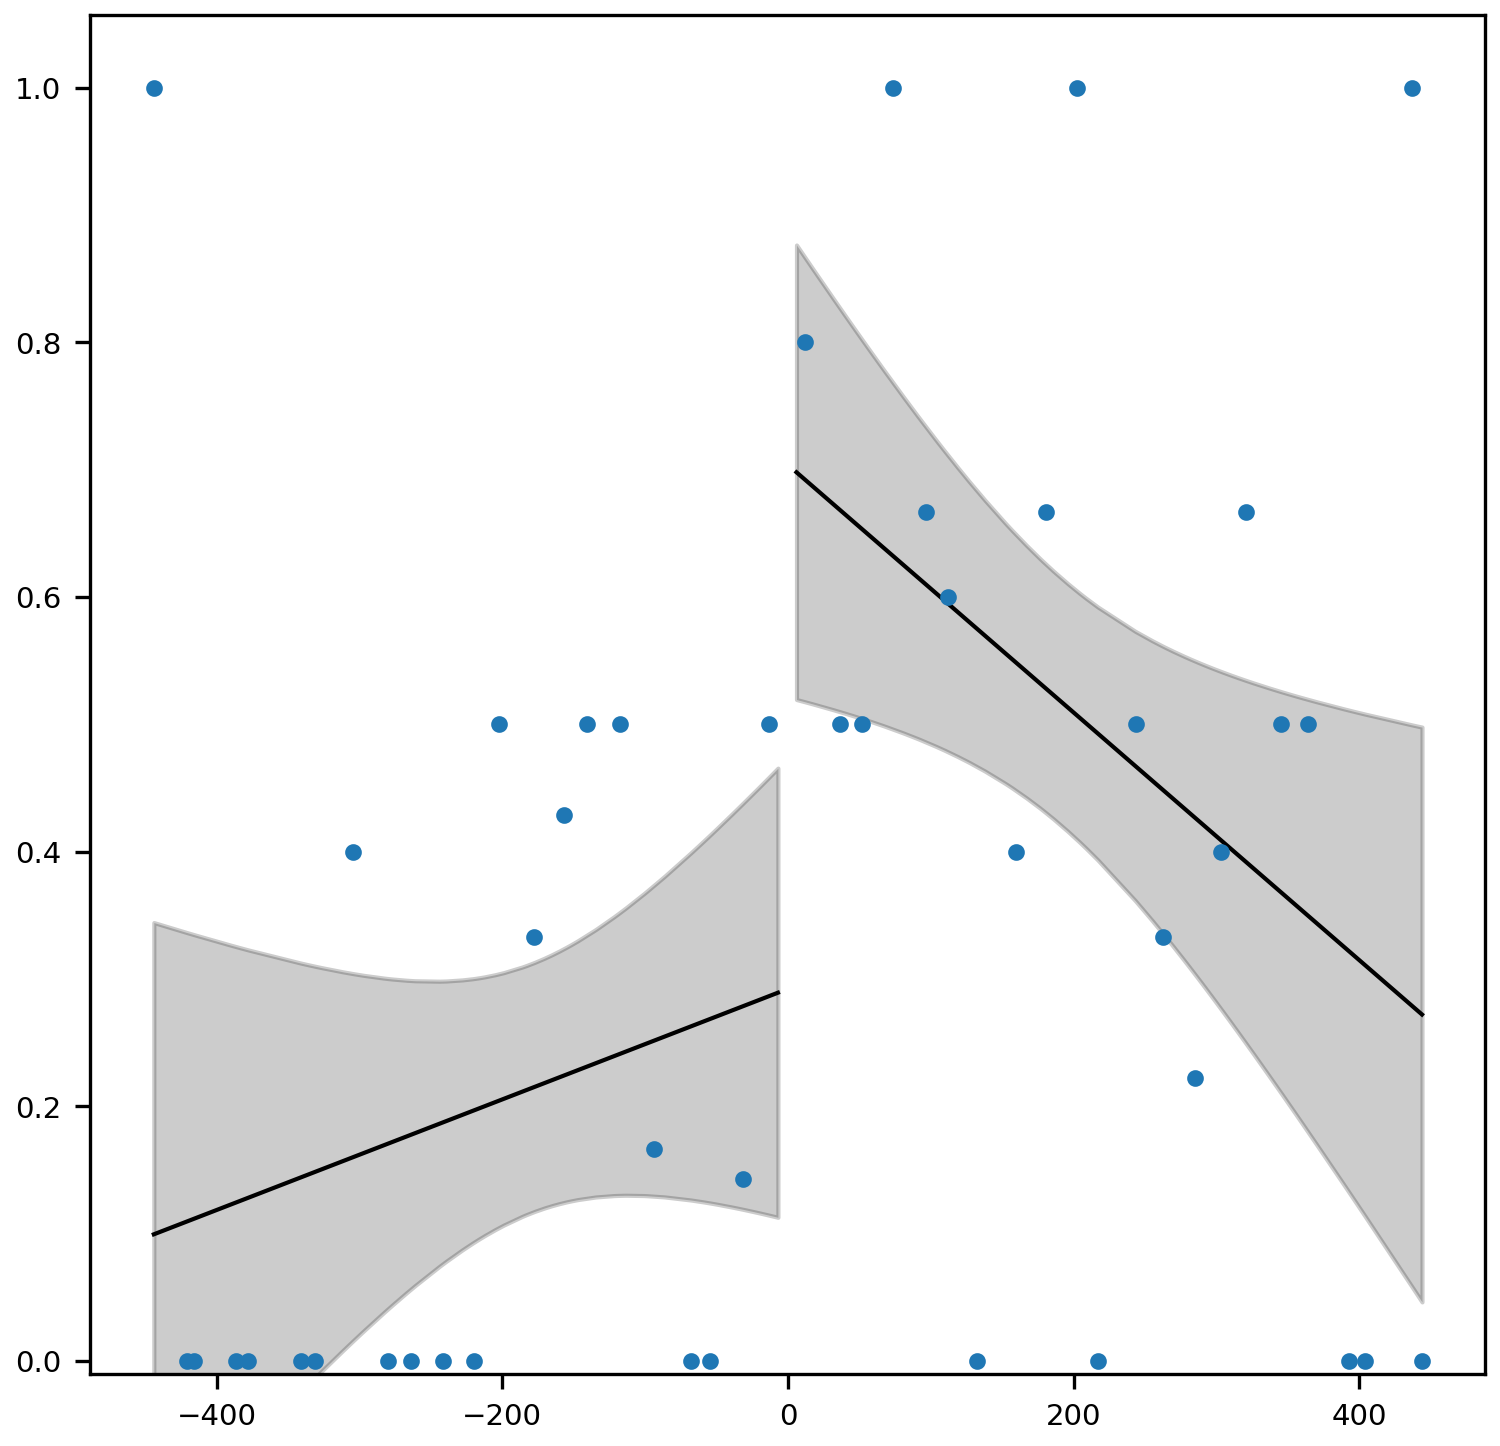

                    Results: Ordinary least squares
Model:                 OLS                Adj. R-squared:       0.108   
Dependent Variable:    changeCHANGES      AIC:                  220.5411
Date:                  2019-09-13 12:22   BIC:                  239.3205
No. Observations:      169                Log-Likelihood:       -104.27 
Df Model:              5                  F-statistic:          5.309   
Df Residuals:          163                Prob (F-statistic):   0.000151
R-squared:             0.134              Scale:                0.20851 
------------------------------------------------------------------------
                           Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
------------------------------------------------------------------------
Intercept                  0.3032   0.1295  2.3419 0.0192  0.0495 0.5570
afterEvent                 0.3972   0.1916  2.0730 0.0382  0.0217 0.7727
reldate                    0.0006   0.0015  0.4012 0.6883 -0.0023 0.0035

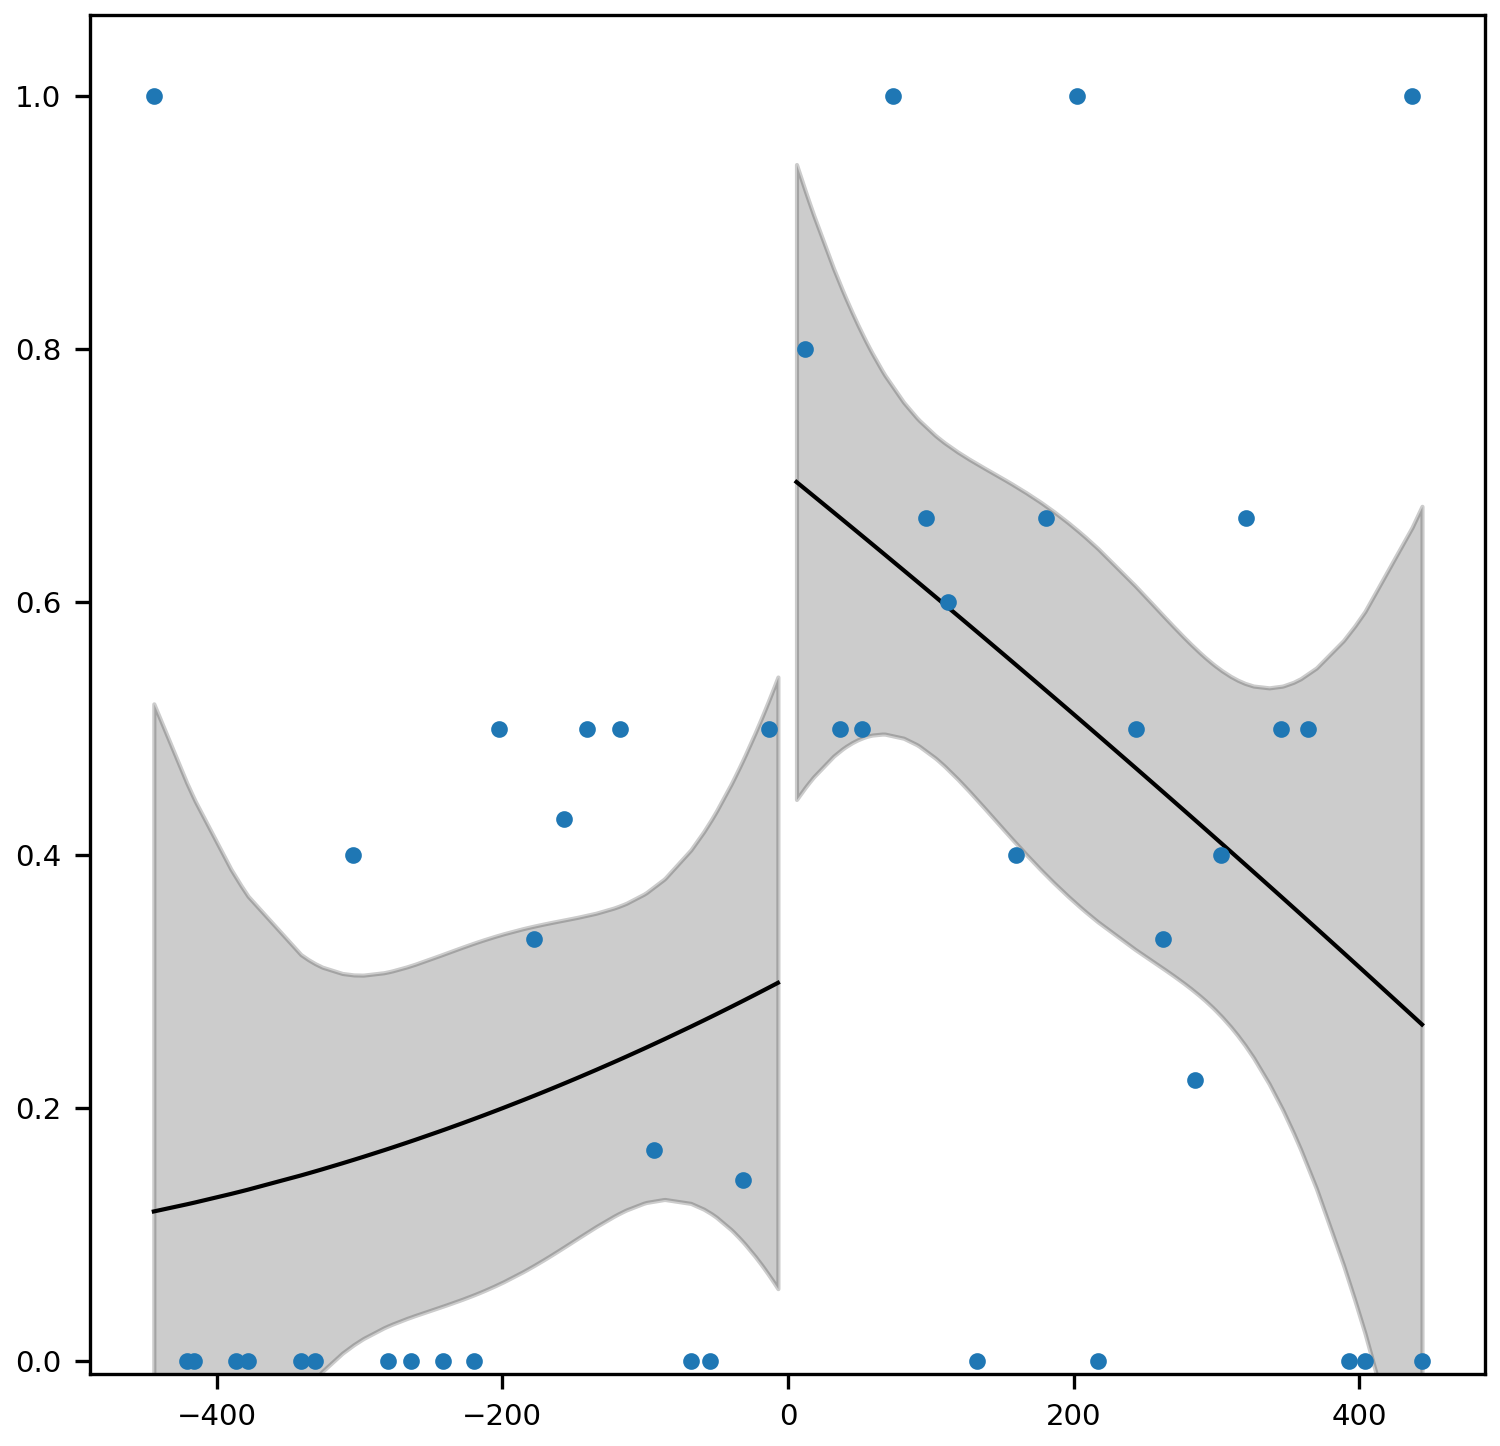

In [ ]:
for degree in [1, 2]:
    rdd(date_intro_template, 450, 'CHANGES', features, 21, degree=degree)

However, we do not detect significant effects on documentation or test-suite updates.

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     -0.039  
Dependent Variable: changeDoc        AIC:                99.5762 
Date:               2019-09-13 12:22 BIC:                108.5126
No. Observations:   69               Log-Likelihood:     -45.788 
Df Model:           3                F-statistic:        0.1284  
Df Residuals:       65               Prob (F-statistic): 0.943   
R-squared:          0.007            Scale:              0.23434 
-----------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
-----------------------------------------------------------------
Intercept           0.2669   0.1641  1.6262 0.1039 -0.0548 0.5885
afterEvent          0.1529   0.2469  0.6191 0.5358 -0.3311 0.6368
reldate            -0.0007   0.0021 -0.3304 0.7411 -0.0048 0.0034
afterEvent:reldate -0.0003   0.0032 -0.1067 0.9150 -0.0067 0.0060
---------------------------

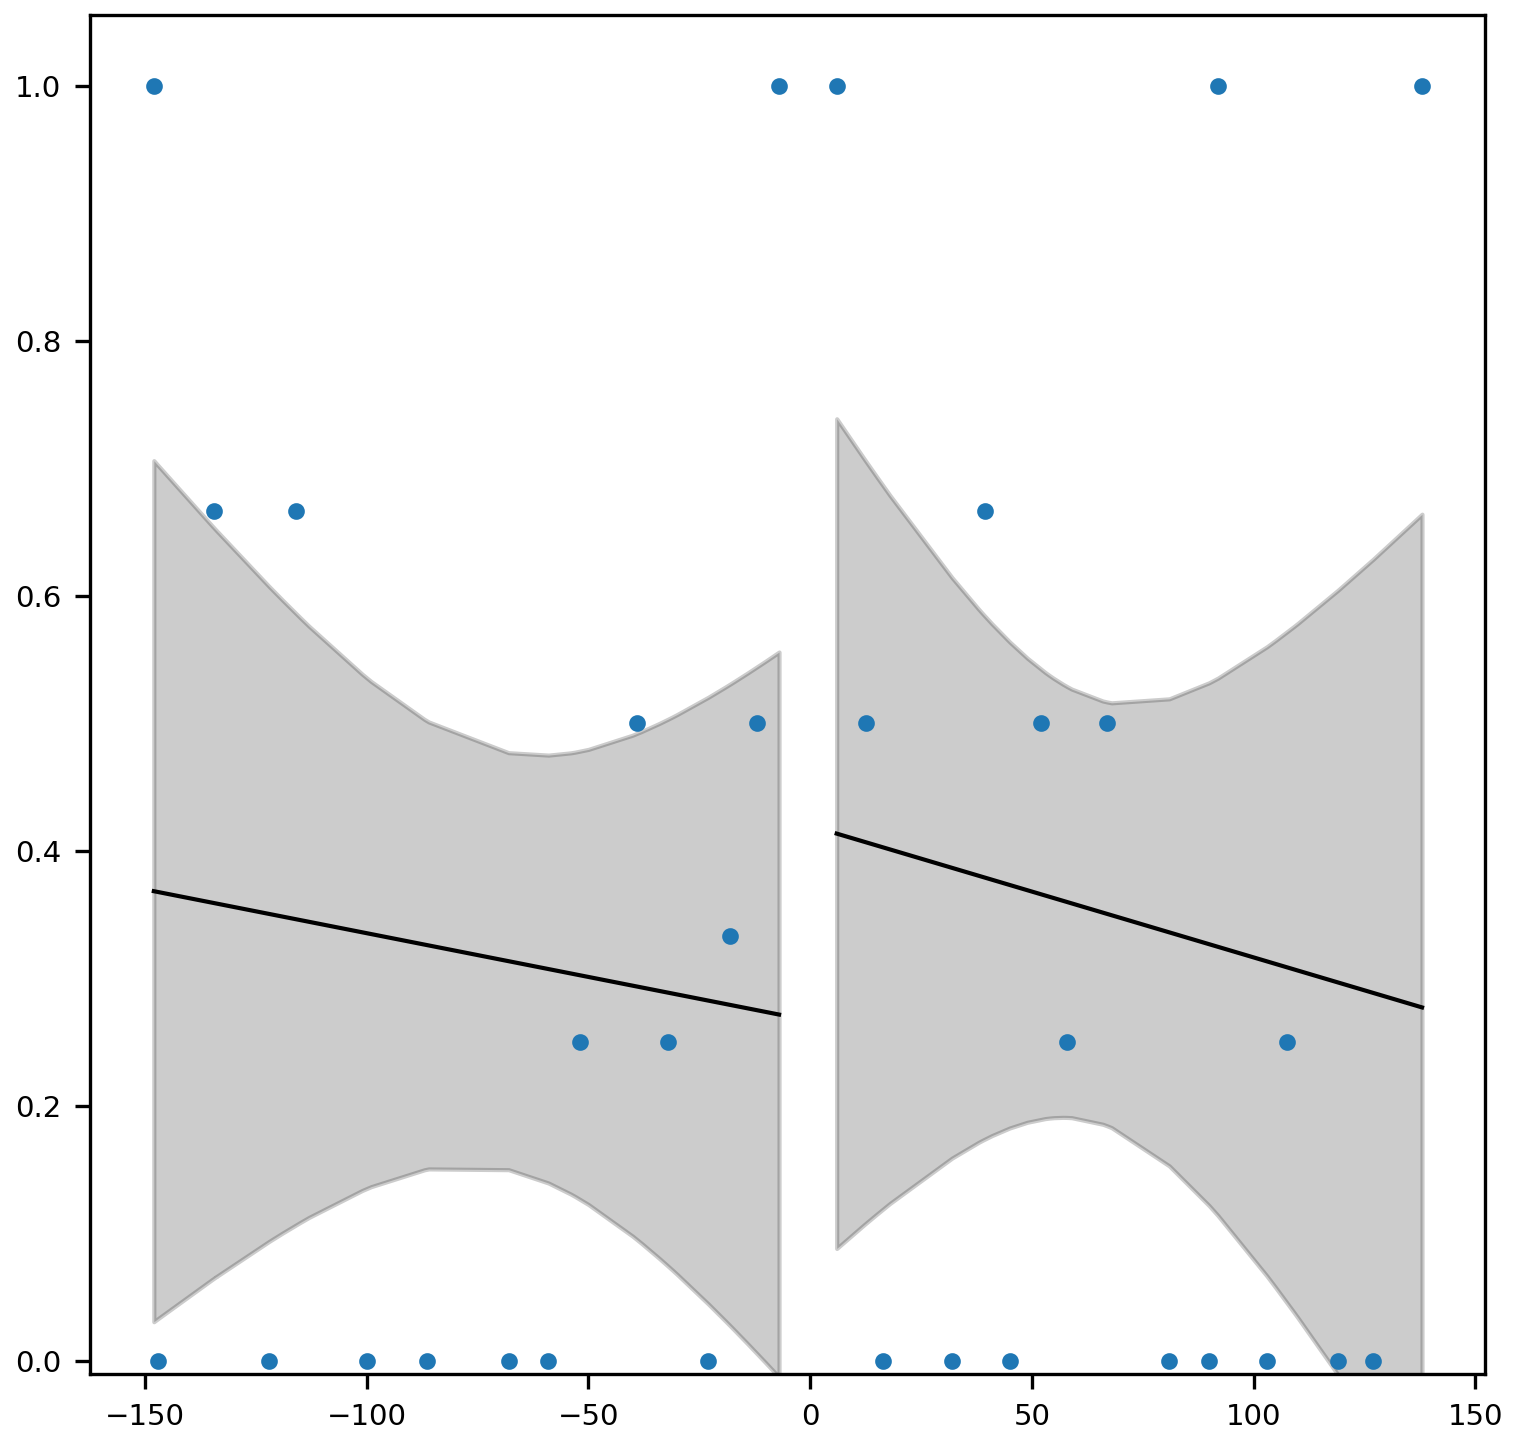

In [ ]:
rdd(date_intro_template, 150, 'Doc', features)

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     -0.001  
Dependent Variable: changeTests      AIC:                106.5312
Date:               2019-09-13 12:24 BIC:                115.5252
No. Observations:   70               Log-Likelihood:     -49.266 
Df Model:           3                F-statistic:        1.194   
Df Residuals:       66               Prob (F-statistic): 0.319   
R-squared:          0.042            Scale:              0.25374 
-----------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
-----------------------------------------------------------------
Intercept           0.2052   0.1634  1.2557 0.2092 -0.1151 0.5255
afterEvent          0.3549   0.2555  1.3892 0.1648 -0.1458 0.8556
reldate            -0.0033   0.0018 -1.8364 0.0663 -0.0069 0.0002
afterEvent:reldate  0.0025   0.0027  0.9400 0.3472 -0.0027 0.0077
---------------------------

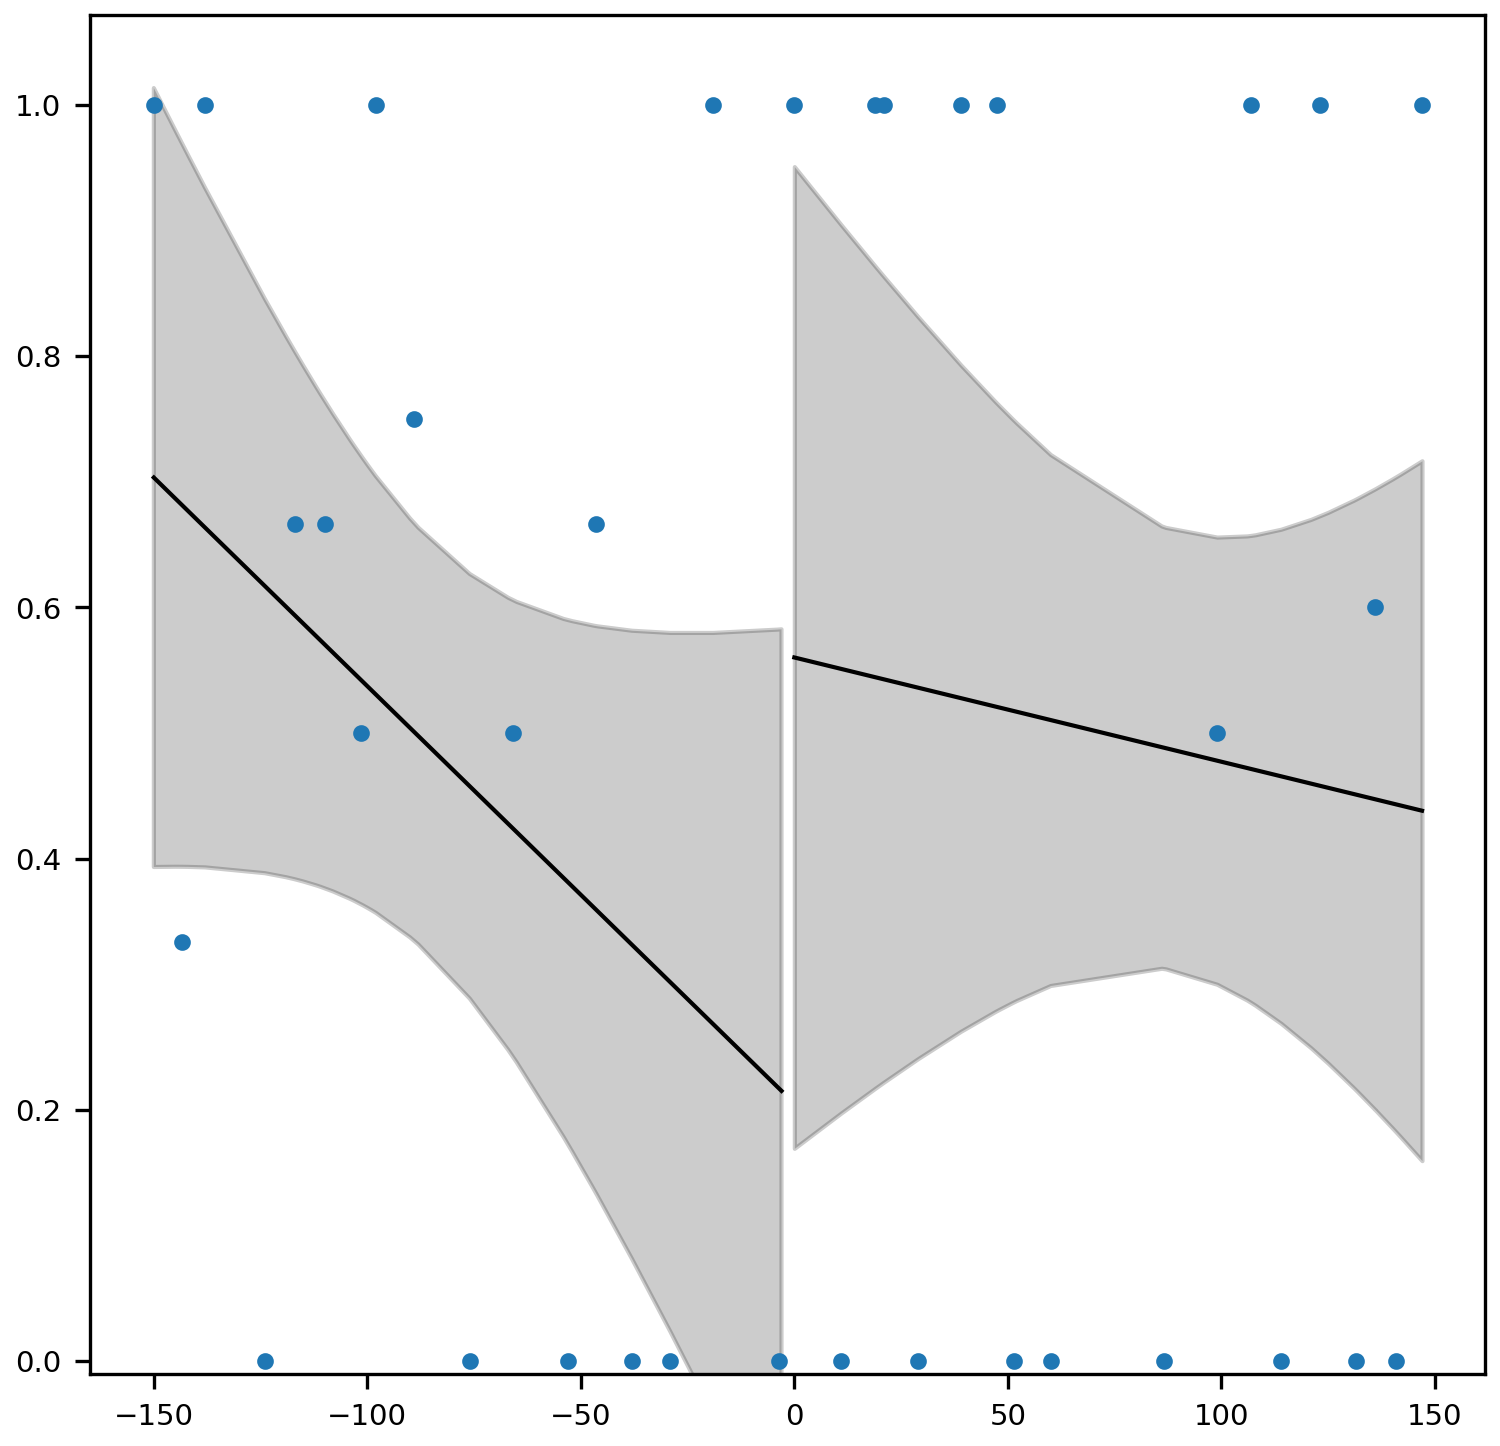

In [ ]:
rdd(date_tests_template, 150, 'Tests', features)

#### Effect on bugfix pull requests

These pull requests should also frequently introduce new regression tests.

In [ ]:
bugfixes = values[values['fix']]
len(bugfixes) / len(values)

0.2970973249857712

We do not observe any effect on the number pull requests fixing bugs that include a test file.

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.005   
Dependent Variable: changeTests      AIC:                503.8745
Date:               2019-09-13 12:24 BIC:                519.3630
No. Observations:   355              Log-Likelihood:     -247.94 
Df Model:           3                F-statistic:        1.681   
Df Residuals:       351              Prob (F-statistic): 0.171   
R-squared:          0.014            Scale:              0.23938 
-----------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
-----------------------------------------------------------------
Intercept           0.3904   0.0703  5.5558 0.0000  0.2527 0.5281
afterEvent          0.0461   0.0996  0.4632 0.6432 -0.1490 0.2413
reldate             0.0006   0.0008  0.7175 0.4731 -0.0010 0.0022
afterEvent:reldate -0.0003   0.0012 -0.2771 0.7817 -0.0026 0.0020
---------------------------

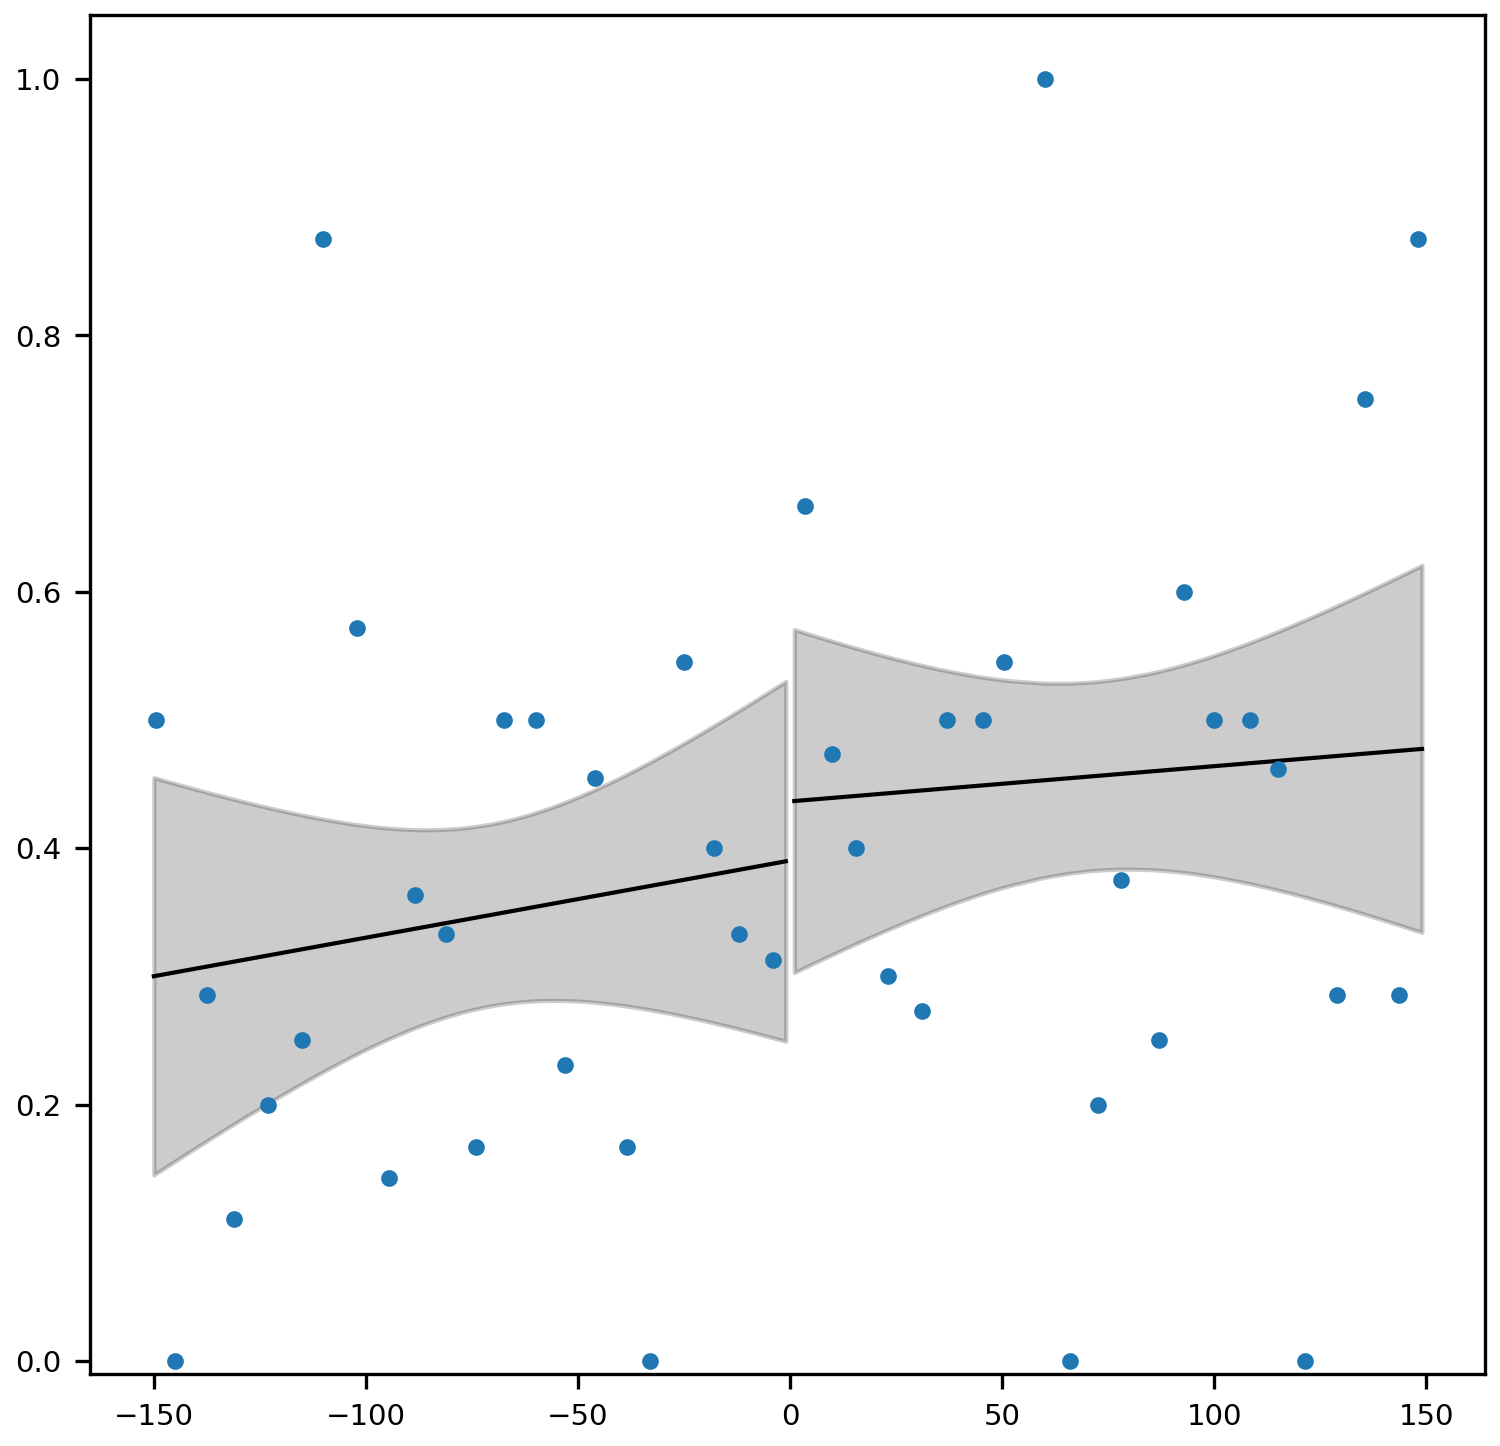

In [ ]:
rdd(date_tests_template, 150, 'Tests', bugfixes)